In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
from functions import *
import matplotlib.animation as animation
from tqdm import tqdm
from matplotlib.lines import Line2D

## Control8/HFS8 data

### Data structure

This dataset comprises neural recordings collected from three monkeys, resulting in a total of 777 recorded neurons under both Control and HFS conditions. Only a subset of the neurons (equivalent to 10%) had at least 40 HFS trials that covered all eight targets. For each neuron, the data was structured into two matrices of size Tr, representing the number of trials, and 4000 ms, indicating the duration of the recording containing the spike trains that were aligned with respect to an event of interest (CUE, GO, or TO signal).

The number of trials varied across neurons and conditions, with a significantly higher number of trials observed under the Control condition. Additionally, the distribution of targets across the trials was not uniform, with some targets being more challenging to reach for the monkeys.

### Pre-processing of the data

To process both Control and HFS data, we follow the same procedure. Firstly, we select neurons that have at least 40 trials for both conditions and at least one trial per target. Then, we convolve the spike trains with a Gaussian kernel of parameter σ=100 ms to create firing rates. We ensure that the number of trials for a given neuron and target matches between Control and HFS by sampling trials.

Next, we group trials for each neuron that correspond to the same cued target and compute their average value. This results in a tensor of size (number of neurons x number of targets x number of time bins) called X. Finally, we select a time bin for each neuron and z-score the data over the target dimension. 
    
$$X_{\textrm{z-scored}} = \frac{X - <X>_\textrm{targets}}{\textrm{std}_\textrm{targets}(X)}$$    

### Target-related manifold dimensionality D_pca

A PCA is conducted for the z-scored data which gives eigenvalues denoted λn. We define D_pca as 

$$D_{pca} = \frac{(\sum_n \lambda_n)^2}{\sum_n \lambda_n^2}$$

### PCA for both Control and HFS

We apply the same pre-processing method, but for the concatenation of Control and HFS data over the target axis: instead of having 8 conditions, one for each target, we now have 8x2.

# Computing Dpca

In [102]:
# Load the data from the .npy files

centering = 'GO'

dic_cont8 = get_data('dic_cont8_'+centering+'.npy')
dic_hfs = get_data('dic_hfs_'+centering+'.npy')
dic_tot = get_data('dic_tot_'+centering+'.npy')

# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)
dic_hfs = smoothen_data(dic_hfs, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]
    
nb_trials_hfs = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_hfs[i] = dic_hfs['target'][i].shape[0]
    
number_of_trials_to_consider = np.min([nb_trials_hfs, nb_trials_cont8], axis = 0).astype('int')

In [103]:
print(nb_trials_hfs.mean(), nb_trials_cont8.mean())

28.854568854568853 160.06821106821107


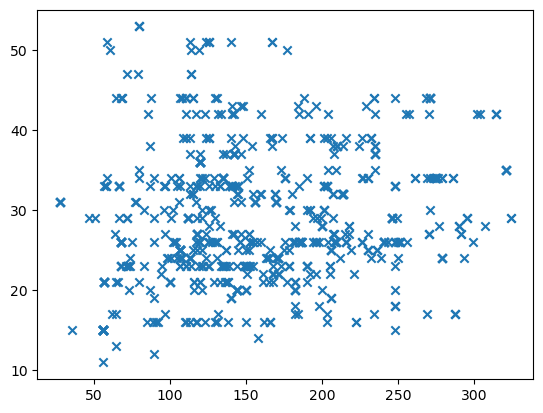

In [104]:
plt.scatter(nb_trials_cont8, nb_trials_hfs, marker = 'x')
#plt.hist(nb_trials_hfs)

In [134]:
def make_a_realization(dic_cont8, dic_hfs, dic_tot, t=1850, window_size = 30, hfs_trial_thresh = 28):
    
    # radomly select trial indices
    (trial_indices_to_consider_cont8, trial_indices_to_consider_hfs) = get_rand_tr_indices_same_nbt_per_target(dic_cont8, dic_hfs)
    
    # Add trial-averaged data to the dictionaries and return the neuron filter that has entry 1 if there is at least one recording per target
    # for this neuron
    (dic_cont8, neuron_filter_cont8) = add_condition_average_to_dic_with_defined_trials(dic_cont8, trial_indices_to_consider_cont8)
    (dic_hfs, neuron_filter_hfs) = add_condition_average_to_dic_with_defined_trials(dic_hfs, trial_indices_to_consider_hfs)

    # Compute the final neuron filter as the element-wise product of the neuron filters obtained from the two datasets
    neuron_filter = neuron_filter_cont8 * neuron_filter_hfs


    # Add to this the fact that we want only neurons with more than hfs_trial_thresh trials
    neuron_filter_many_neurons = (nb_trials_hfs >= hfs_trial_thresh)
    neuron_filter *= neuron_filter_many_neurons
    
    ## ADD THE ZSCORED MATRICES BASED ON THIS NEURON FILTER AND SELECTED TRIALS
    # Get the number of neurons from a previously defined filter
    nb_neurons = neuron_filter.shape[0]

    # Create an empty list in the dictionary "dic_tot" to store the concatenated matrices
    dic_tot['mat_cond_avg'] = []

    # Loop through each neuron
    for neuron in range(nb_neurons):
        # Concatenate the matrices for the same neuron from the control8 and HFS8 dictionaries
        res = np.concatenate((dic_cont8['mat_cond_avg'][neuron] , dic_hfs['mat_cond_avg'][neuron]), axis = 0 )

        # Add the concatenated matrix to the list in the "dic_tot" dictionary
        dic_tot['mat_cond_avg'].append(res)

    # Add z-scored matrices to each of the three dictionaries using the "add_zscored_to_dic" function
    # The matrices will be based on a time window of 30 time steps centered around time step 1850
    # The "test_set" argument is set to False
    dic_tot = add_zscored_to_dic(dic_tot, t, window_size, test_set = False)
    dic_cont8 = add_zscored_to_dic(dic_cont8, t, window_size, test_set = False)
    dic_hfs = add_zscored_to_dic(dic_hfs, t, window_size, test_set = False)

    ## DO THE PCAs
    eigvals, eigvects, eigvals_cont, eigvects_cont, eigvals_hfs, eigvects_hfs = perform_PCAs(dic_tot, dic_cont8, dic_hfs, neuron_filter, t, window_size)

    return eigvals_cont, eigvals_hfs

In [6]:
t = 1900 #Time offset for selecting data. The event signal is located at t=2000 (ms)
window_size = 5 #Window size for selecting data.
hfs_trial_thresh = 40 #np.median(nb_trials_hfs).astype('int')
(nb_trials_hfs >= hfs_trial_thresh).sum()

74

In [16]:
eigvals_cont_list = []
eigvals_hfs_list = []

nb_real = 100

for k in tqdm(range(nb_real)):
    eigvals_cont, eigvals_hfs = make_a_realization(dic_cont8, dic_hfs, dic_tot, t=2400, window_size = 5, hfs_trial_thresh=40)
    eigvals_cont_list.append(eigvals_cont)
    eigvals_hfs_list.append(eigvals_hfs)
    
eigvals_hfs_list = np.array(eigvals_hfs_list)
eigvals_cont_list = np.array(eigvals_cont_list)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


Text(0.5, 1.0, 'Fraction of the total variance explained by the first 20 eigenvectors')

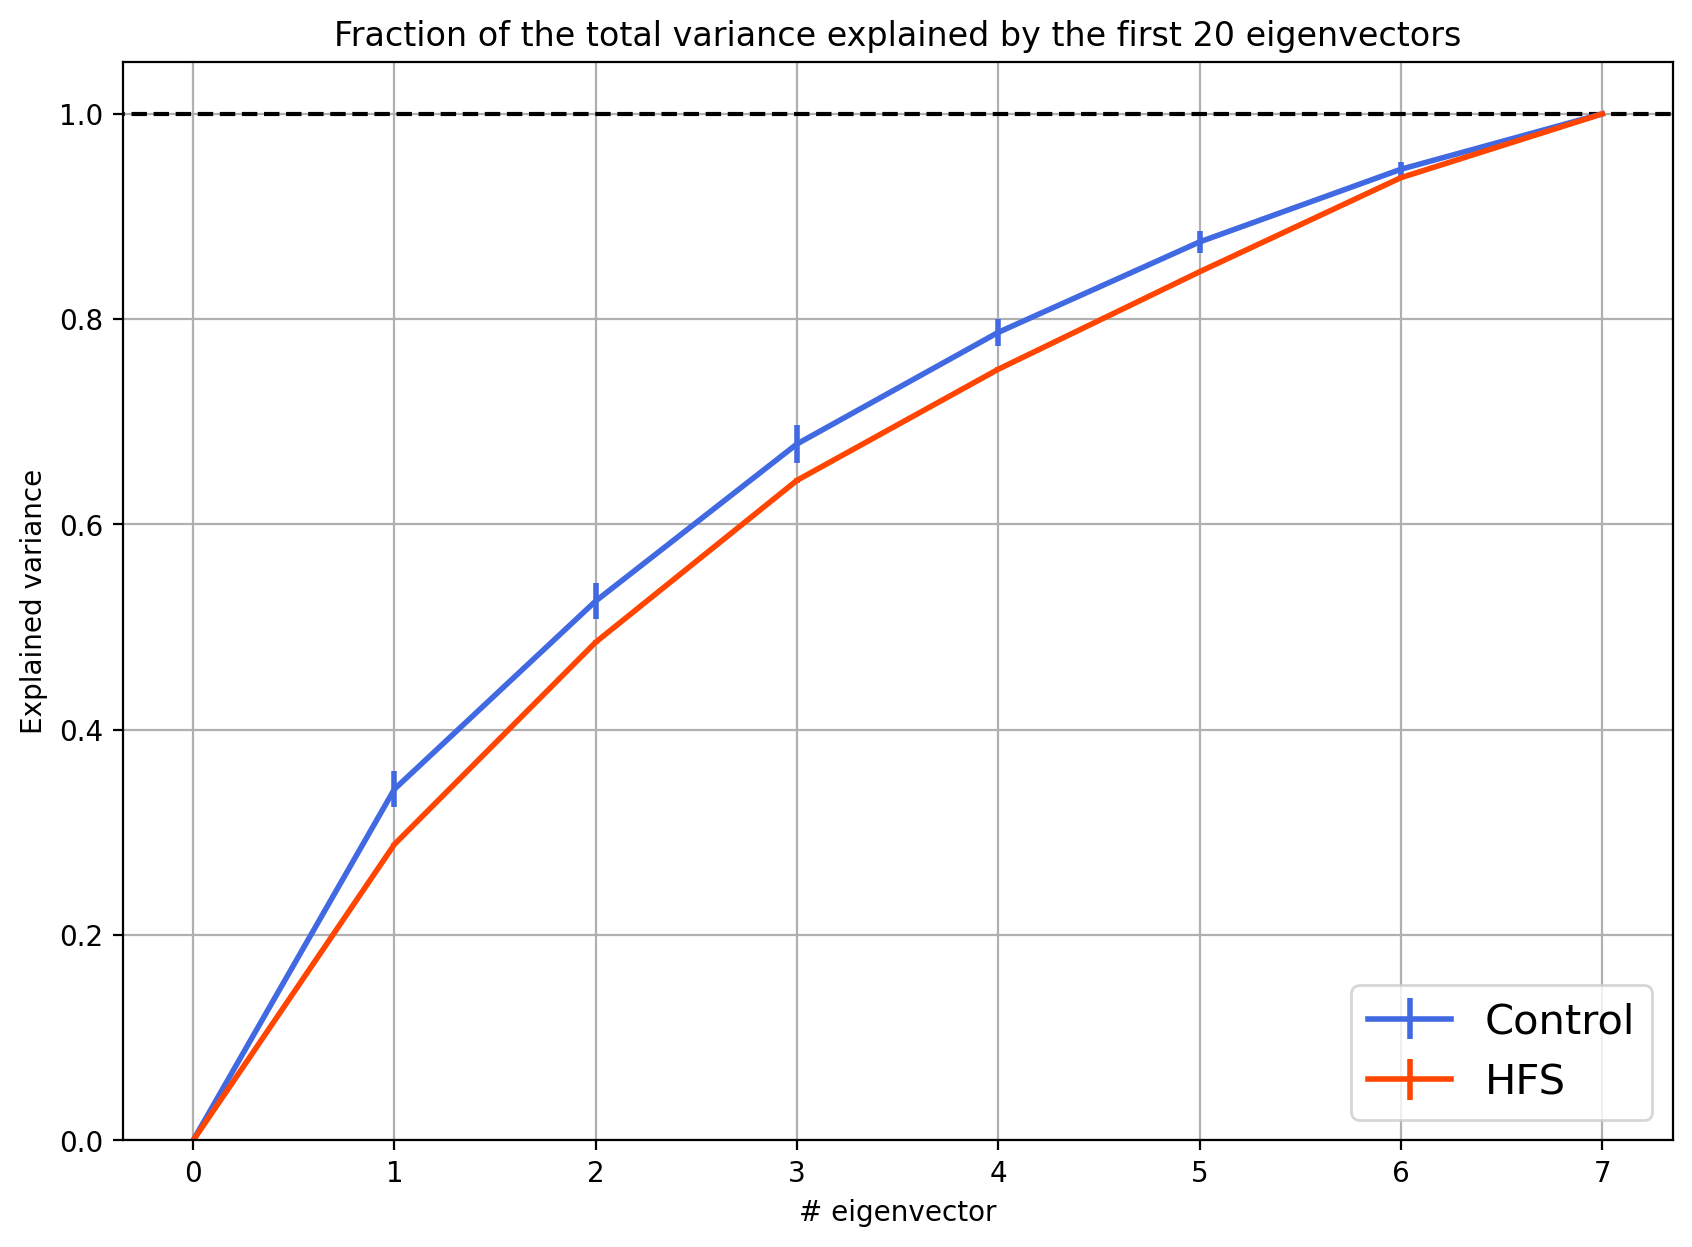

In [17]:
plt.figure(figsize = (10,7), dpi = 200)

var_expl_cont = np.zeros((nb_real, 8))
for i in range(8):
    var_expl_cont[:,i] = eigvals_cont_list[:,::-1][:,0:i].sum(axis = 1) / eigvals_cont_list.sum(axis = 1)
    

    
var_expl_hfs = np.zeros((nb_real, 8))
for i in range(8):
    var_expl_hfs[:,i] = eigvals_hfs_list[:,::-1][:,0:i].sum(axis=1) / eigvals_hfs_list.sum(axis=1)
    
    
plt.errorbar(np.arange(8), var_expl_cont.mean(axis=0), yerr = var_expl_cont.std(axis=0) ,color ='royalblue', label = 'Control', linewidth = 2)
plt.errorbar(np.arange(8), var_expl_hfs.mean(axis=0), yerr = var_expl_hfs.std(axis=0) ,color ='orangered', label = 'HFS', linewidth = 2)


plt.legend(fontsize = 15)
plt.xticks(ticks = np.arange(0,8))
plt.grid()
plt.axhline(1,-1,8, c = 'k', linestyle = '--')
plt.ylim(0,1.05)
plt.xlabel('# eigenvector')
plt.ylabel('Explained variance')
plt.title('Fraction of the total variance explained by the first 20 eigenvectors')

#plt.savefig('tot_var_explained_cont8_HFS8.pdf' , transparent=True, bbox_inches="tight")

In [18]:
Dpca_cont = eigvals_cont_list.sum(axis=1)**2/(eigvals_cont_list**2).sum(axis=1)
Dpca_hfs =  eigvals_hfs_list.sum(axis=1)**2/(eigvals_hfs_list**2).sum(axis=1)

print(Dpca_cont.mean(),'+-',  Dpca_cont.std())
print(Dpca_hfs.mean(),'+-',  Dpca_hfs.std())

4.948898923867978 +- 0.20146983883852299
5.561755898100938 +- 0.024359918489121796


In [106]:
def get_Dpca_with_err(dic_cont8, dic_hfs, dic_tot, t=1950, window_size = 30, hfs_trial_thresh = 40 , nb_real = 100):
    eigvals_cont_list = []
    eigvals_hfs_list = []

    for k in tqdm(range(nb_real)):
        eigvals_cont, eigvals_hfs = make_a_realization(dic_cont8, dic_hfs, dic_tot, t=t, window_size = window_size, hfs_trial_thresh = hfs_trial_thresh)
        eigvals_cont_list.append(eigvals_cont)
        eigvals_hfs_list.append(eigvals_hfs)

    eigvals_hfs_list = np.array(eigvals_hfs_list)
    eigvals_cont_list = np.array(eigvals_cont_list)

    Dpca_cont = eigvals_cont_list.sum(axis=1)**2/ (eigvals_cont_list**2).sum(axis=1)
    Dpca_hfs =  eigvals_hfs_list.sum(axis=1)**2/(eigvals_hfs_list**2).sum(axis=1)


    return Dpca_cont.mean(), Dpca_cont.std(), Dpca_hfs.mean(), Dpca_hfs.std()
    

In [123]:
times = [1000,1100,1200,1300,1400,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000,2050,2100,2150,2200,2300,2400] # for GO 
#times = [1200,1300,1400,1500,1550,1600,1650,1700,1750,1800,1850,1900,1950,2000,2050,2100,2150,2200,2250,2300,2350,2400] # for TO 
#times = [1400,1500,1600,1700,1800,1900,2000,2100,2200,2250, 2300,2350, 2400,2450, 2500, 2550, 2600, 2650 , 2700,2800] # for CUE


Dpca_cont_mean = np.zeros(len(times))
Dpca_cont_std = np.zeros(len(times))
Dpca_hfs_mean = np.zeros(len(times))
Dpca_hfs_std = np.zeros(len(times))

window_size = 5
nb_real = 100
hfs_trial_thresh = 0

for k,t in enumerate(times):
    Dpca_cont_mean[k], Dpca_cont_std[k], Dpca_hfs_mean[k], Dpca_hfs_std[k] = get_Dpca_with_err(dic_cont8, dic_hfs, dic_tot, t=t, window_size = window_size , hfs_trial_thresh = hfs_trial_thresh, nb_real = nb_real) 
    
#np.save('Dpcas_'+centering+'_ws_%s_nb_real%s_trial_thresh%s_sigma100.npy'%(window_size,nb_real,hfs_trial_thresh), (Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times))

100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


# Plot of Dpca for different conditions

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

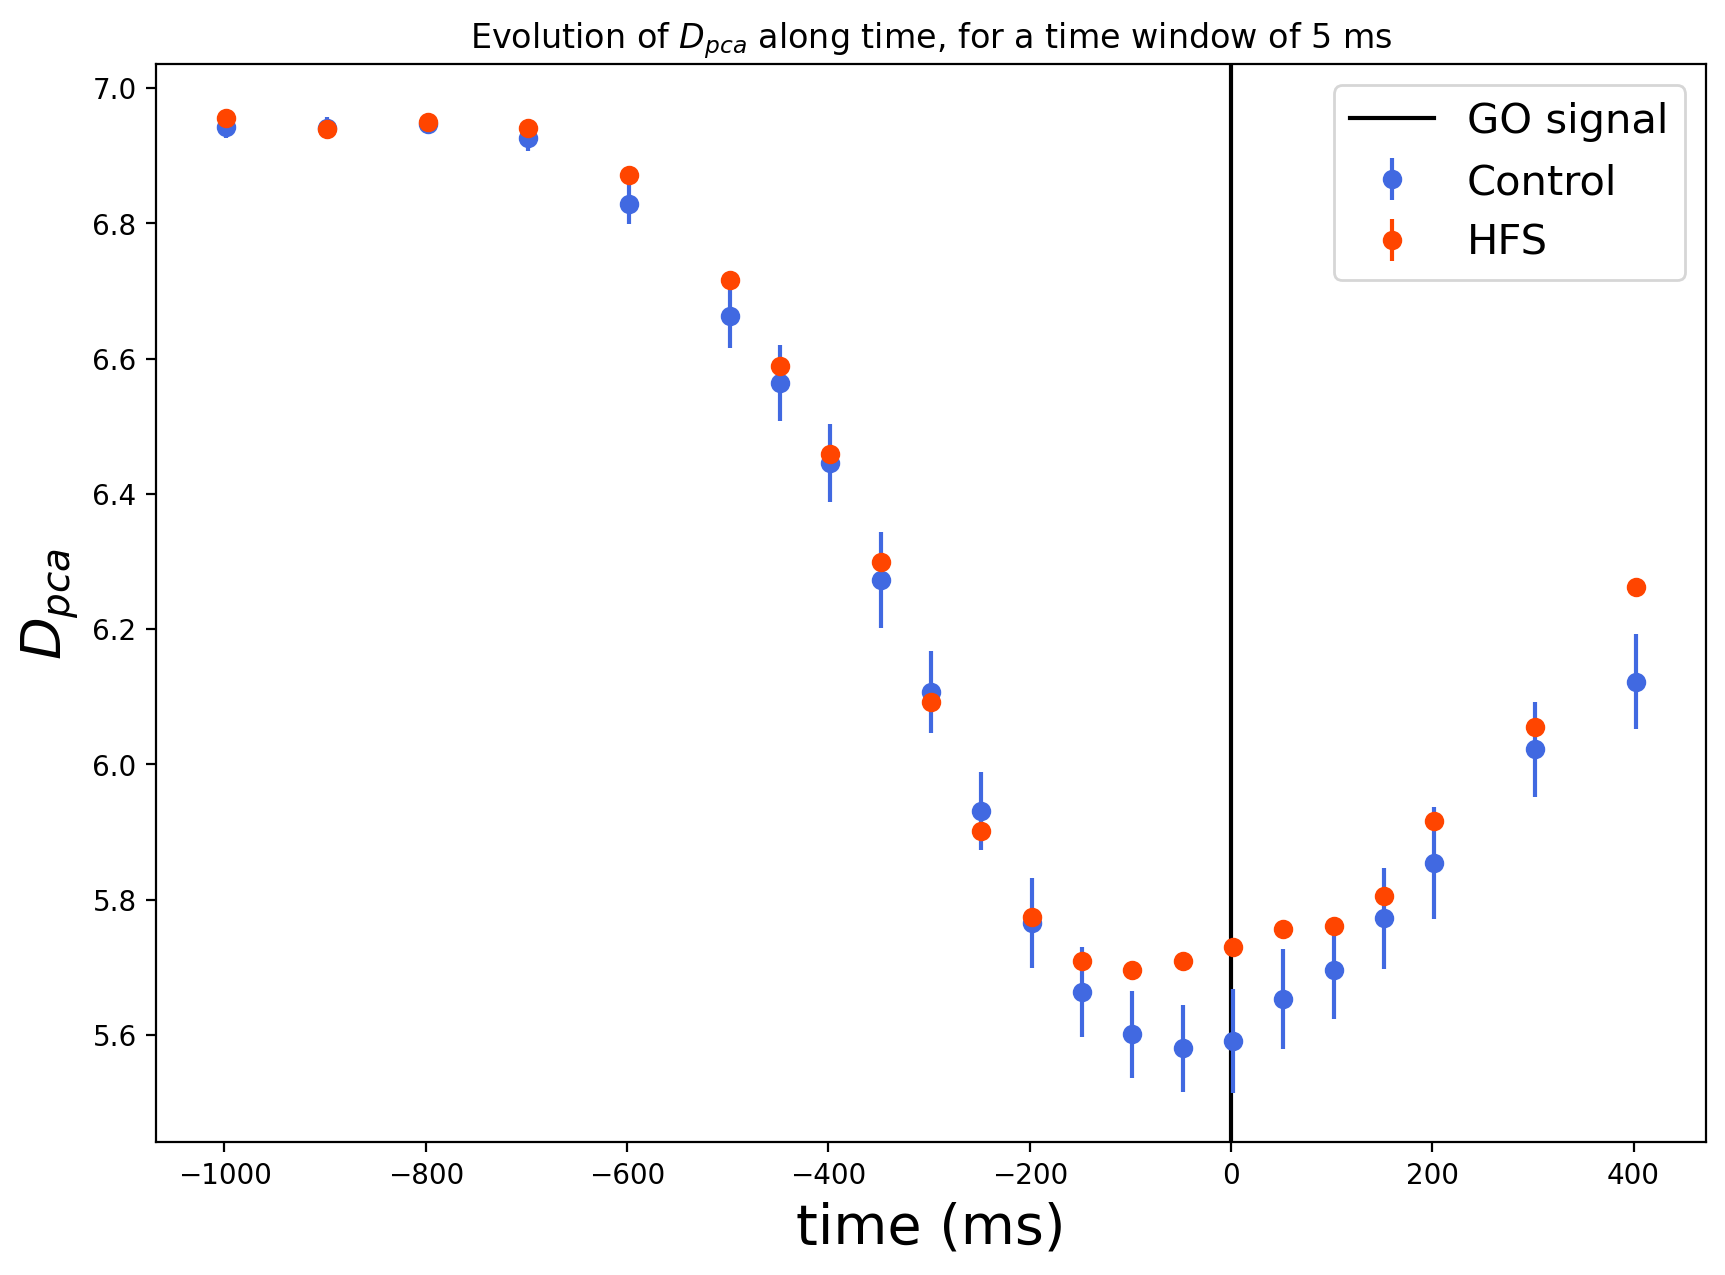

In [125]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_GO_ws_5_nb_real100_trial_thresh0_sigma100.npy')
centering = 'GO'
window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label=centering + ' signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)
#plt.savefig('Dpca_'+centering+'_cont8_HFS8.pdf' , transparent=True, bbox_inches="tight")

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

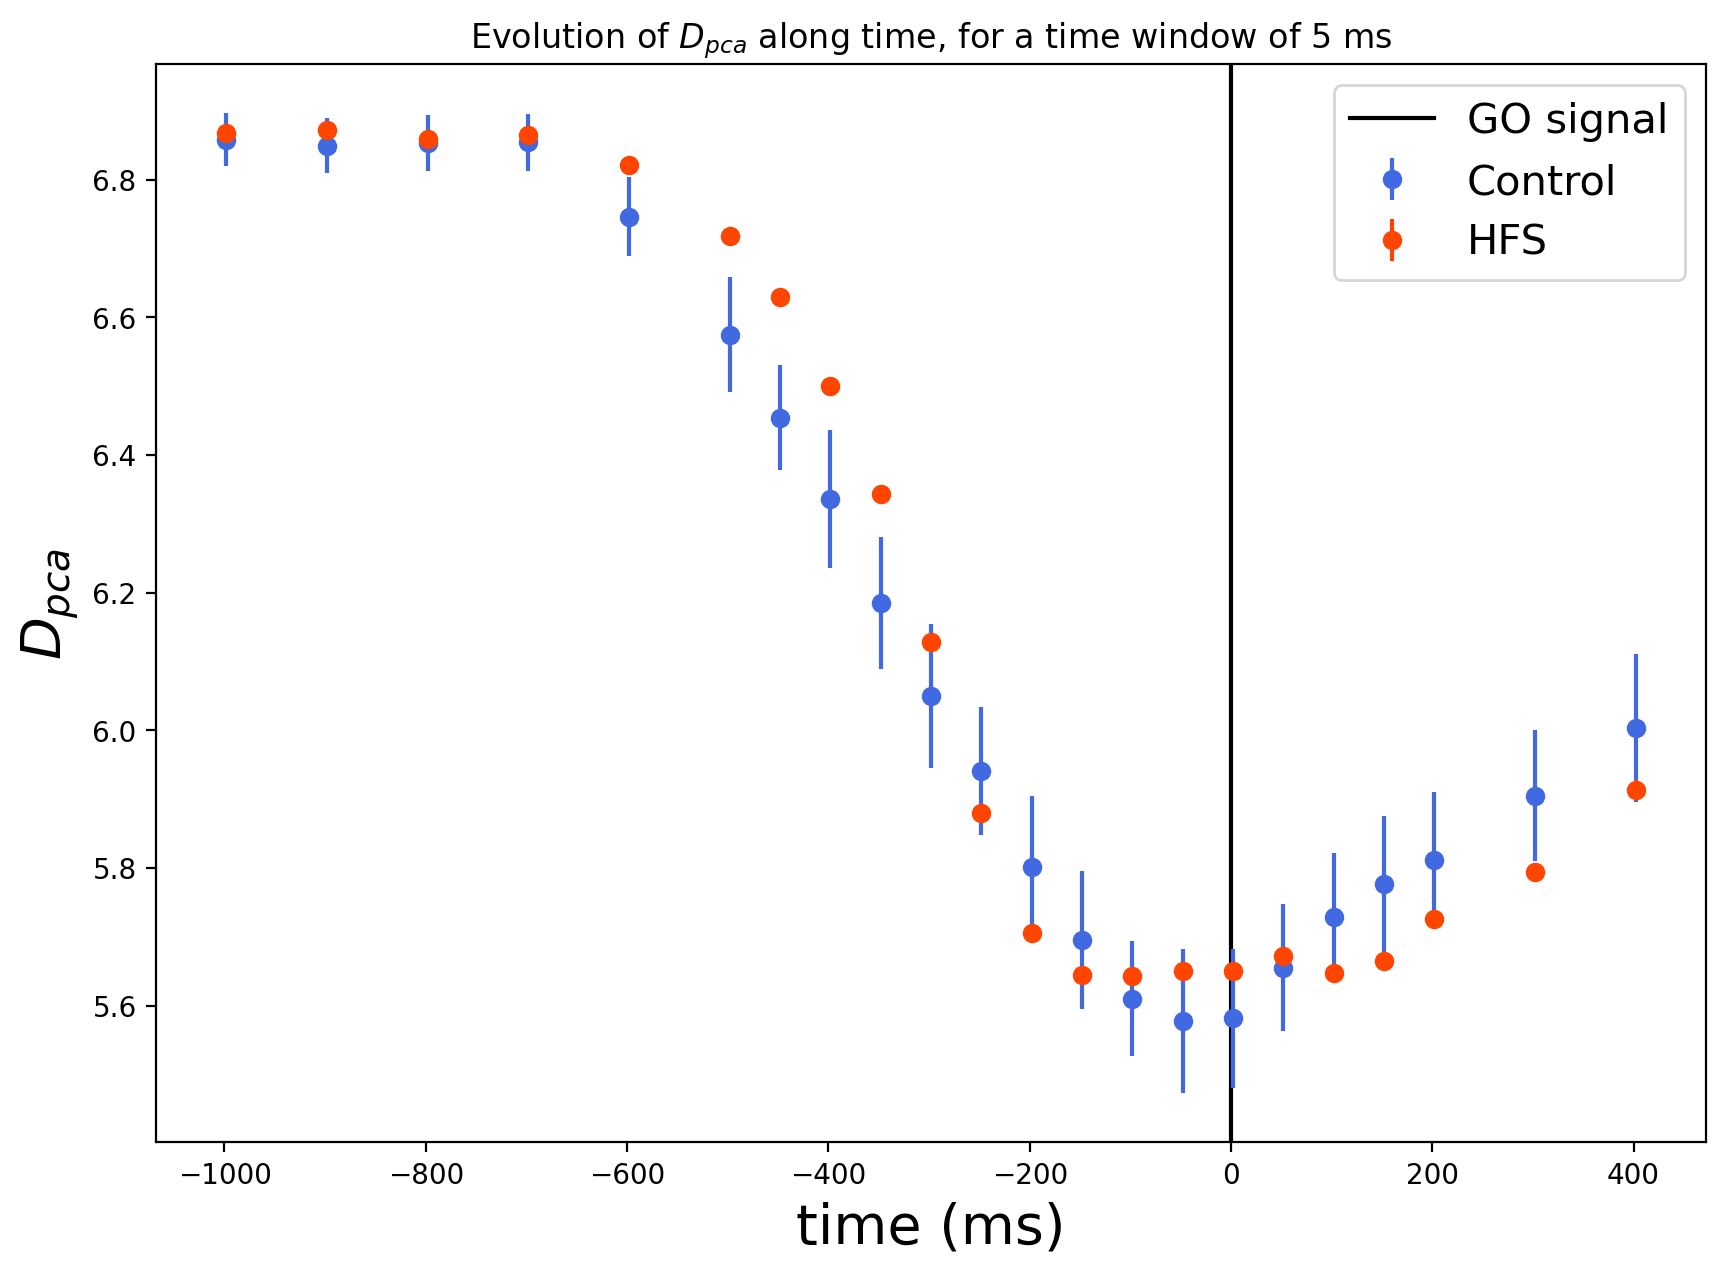

In [110]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_GO_ws_5_nb_real100_trial_thresh30_sigma100.npy')
centering = 'GO'
window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label=centering + ' signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)
#plt.savefig('Dpca_'+centering+'_cont8_HFS8.pdf' , transparent=True, bbox_inches="tight")

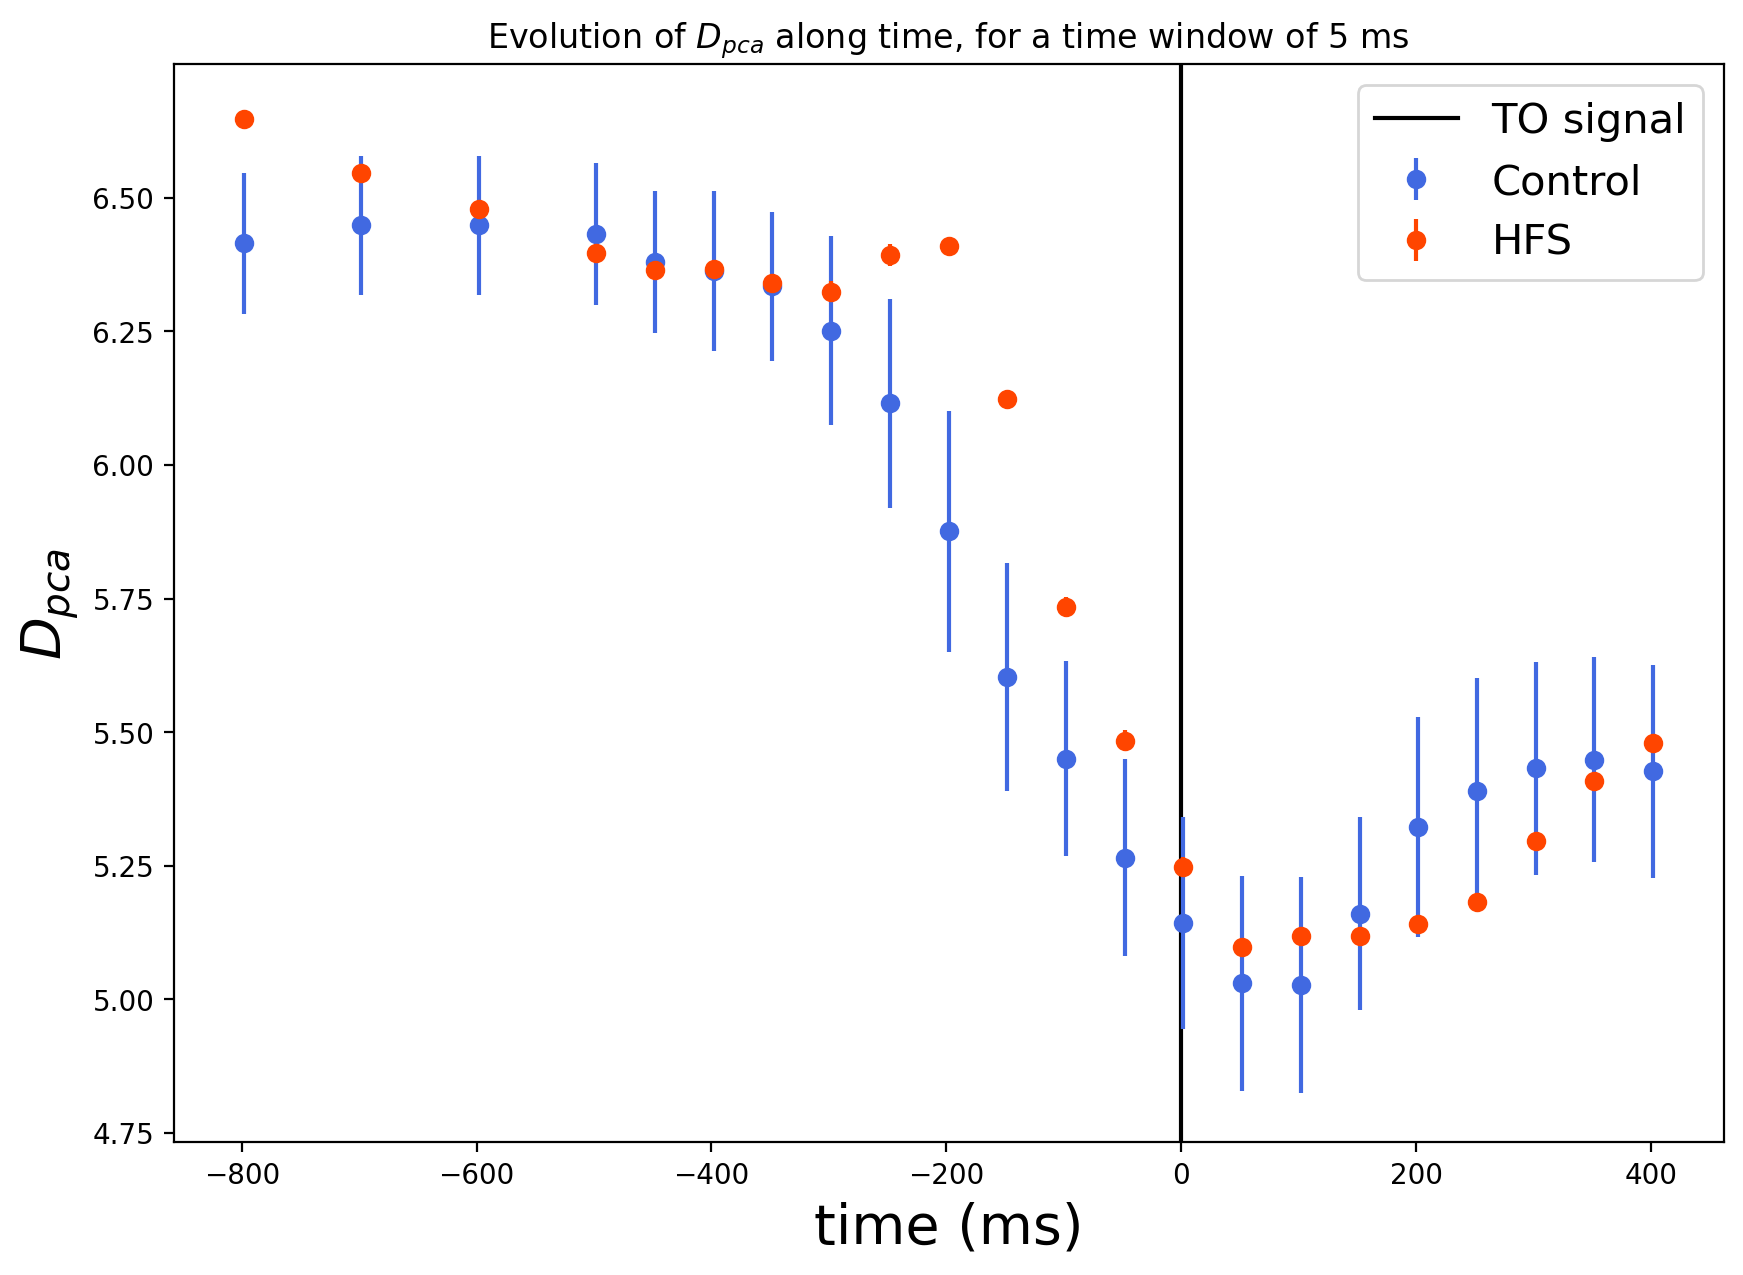

In [202]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_TO_ws_5_nb_real100_trial_thresh40_sigma100.npy')
centering = 'TO'
window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label=centering + ' signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)
#plt.savefig('Dpca_'+centering+'_cont8_HFS8.pdf' , transparent=True, bbox_inches="tight")

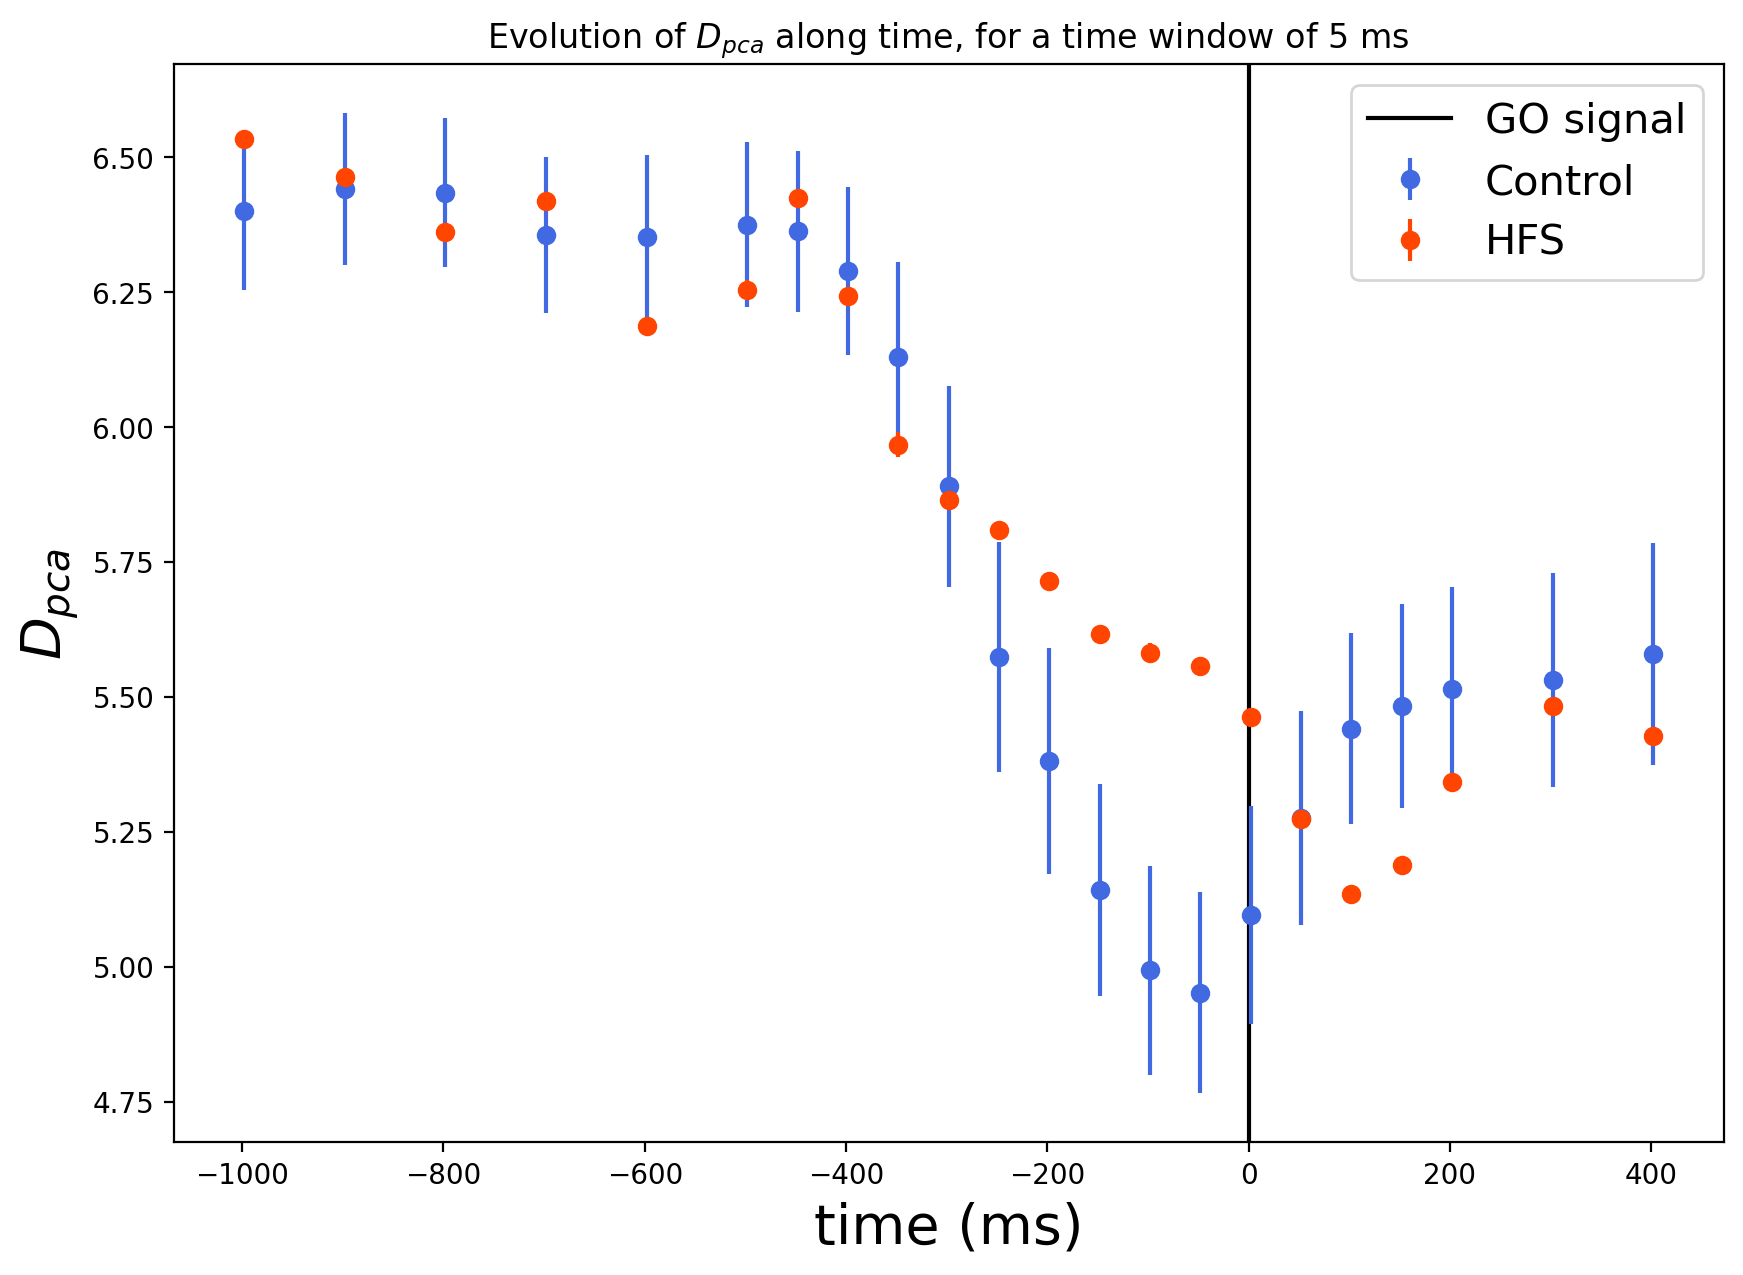

In [203]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_GO_ws_5_nb_real100_trial_thresh40_sigma100.npy')
centering = 'GO'
window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label=centering + ' signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)
#plt.savefig('Dpca_'+centering+'_cont8_HFS8.pdf' , transparent=True, bbox_inches="tight")

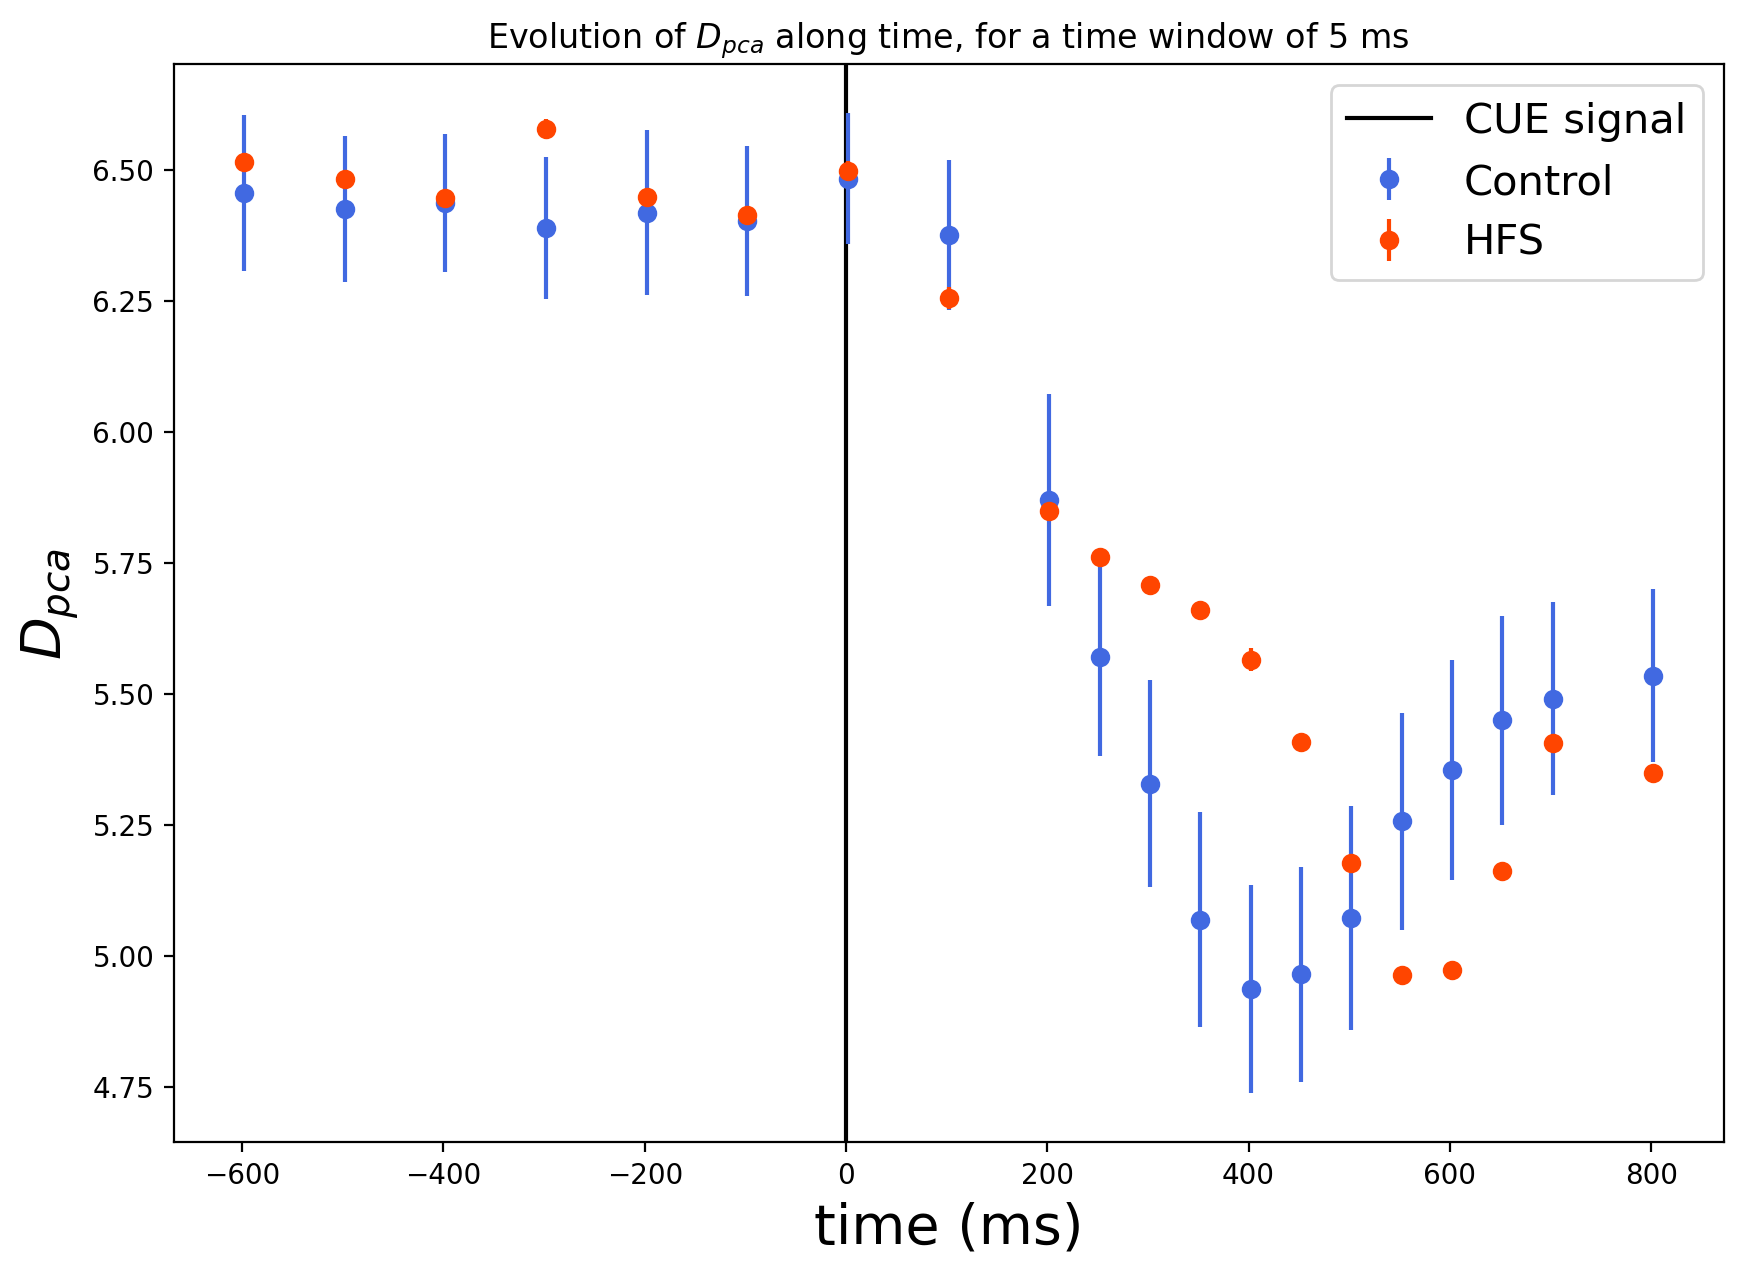

In [204]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_CUE_ws_5_nb_real100_trial_thresh40_sigma100.npy')
centering = 'CUE'
window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label=centering + ' signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)
#plt.savefig('Dpca_'+centering+'_cont8_HFS8.pdf' , transparent=True, bbox_inches="tight")

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

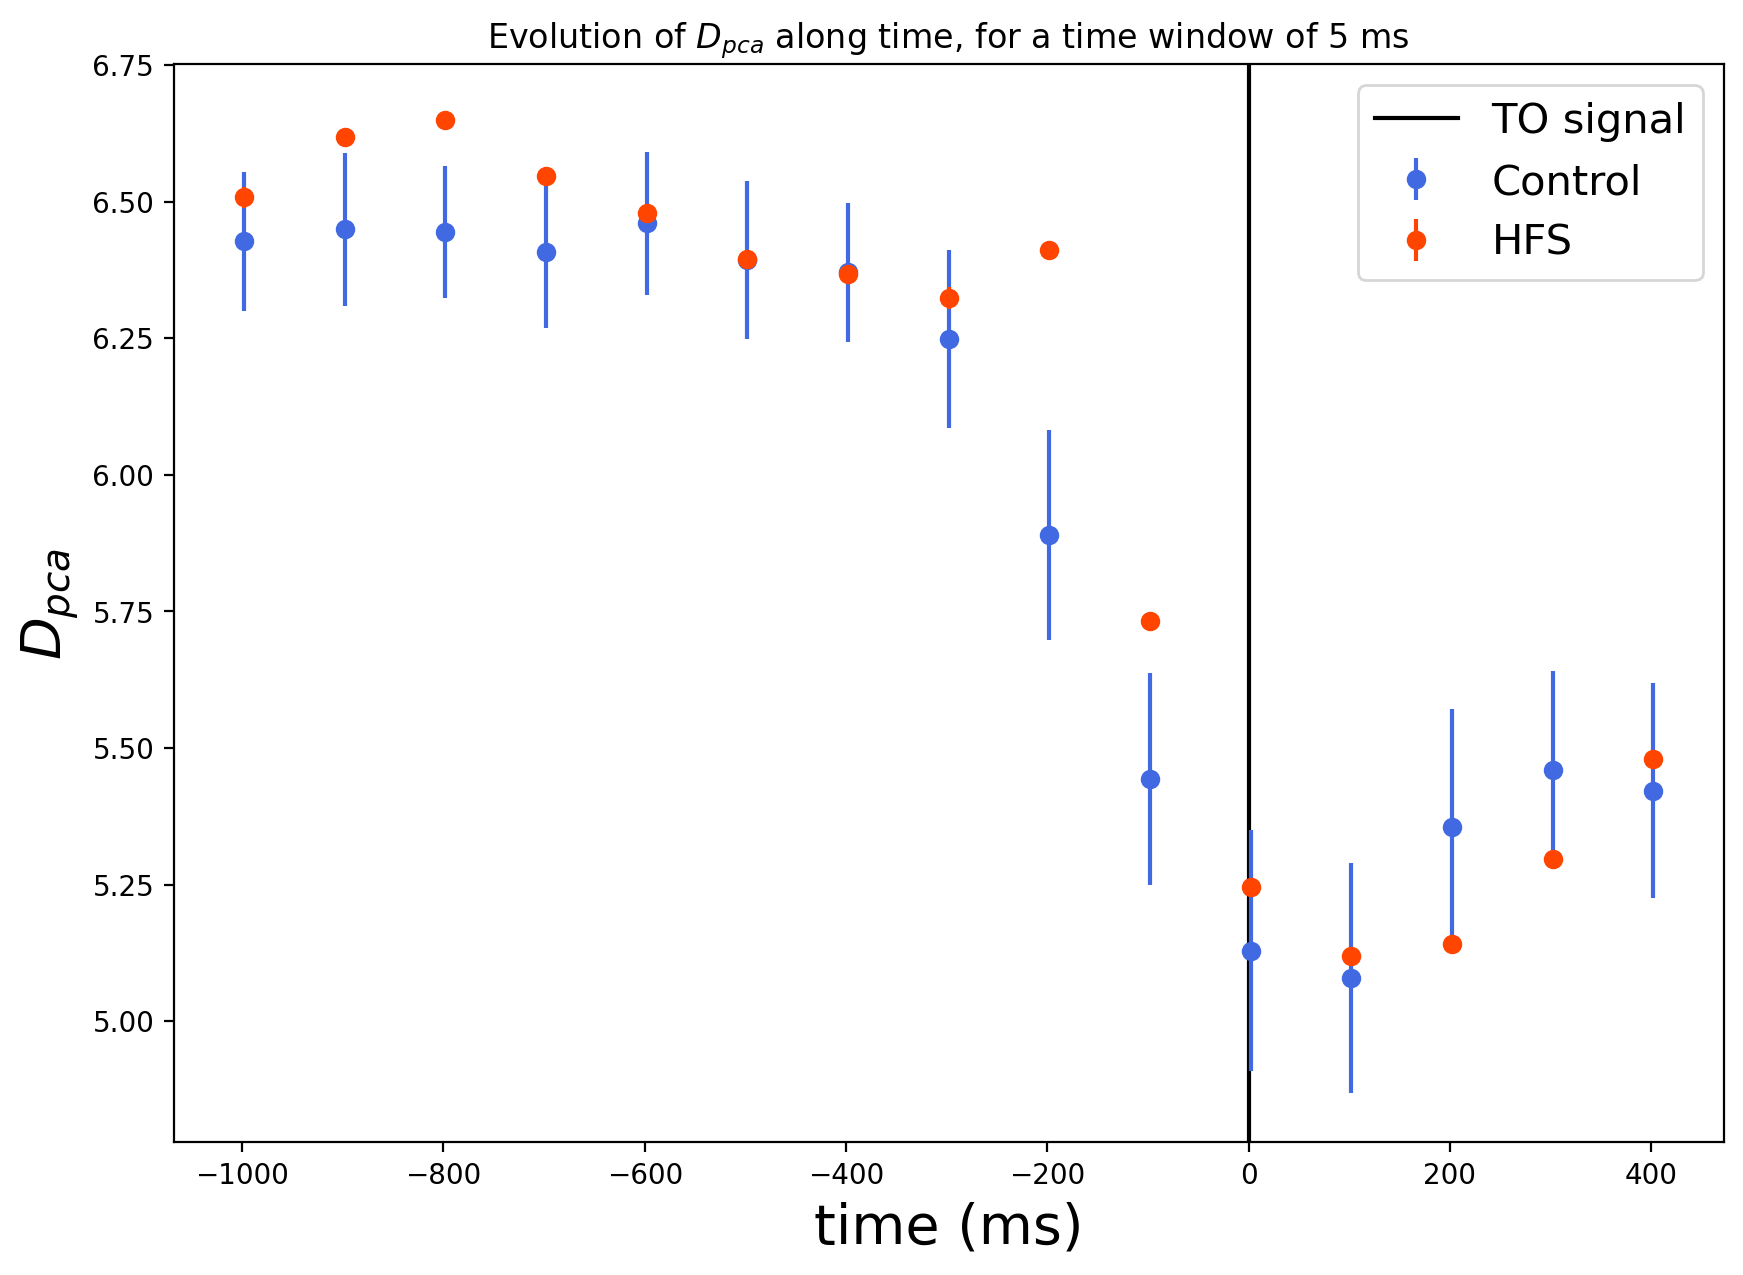

In [14]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_TO_ws_5_nb_real100_trial_thresh40_sigma100.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label=centering + ' signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

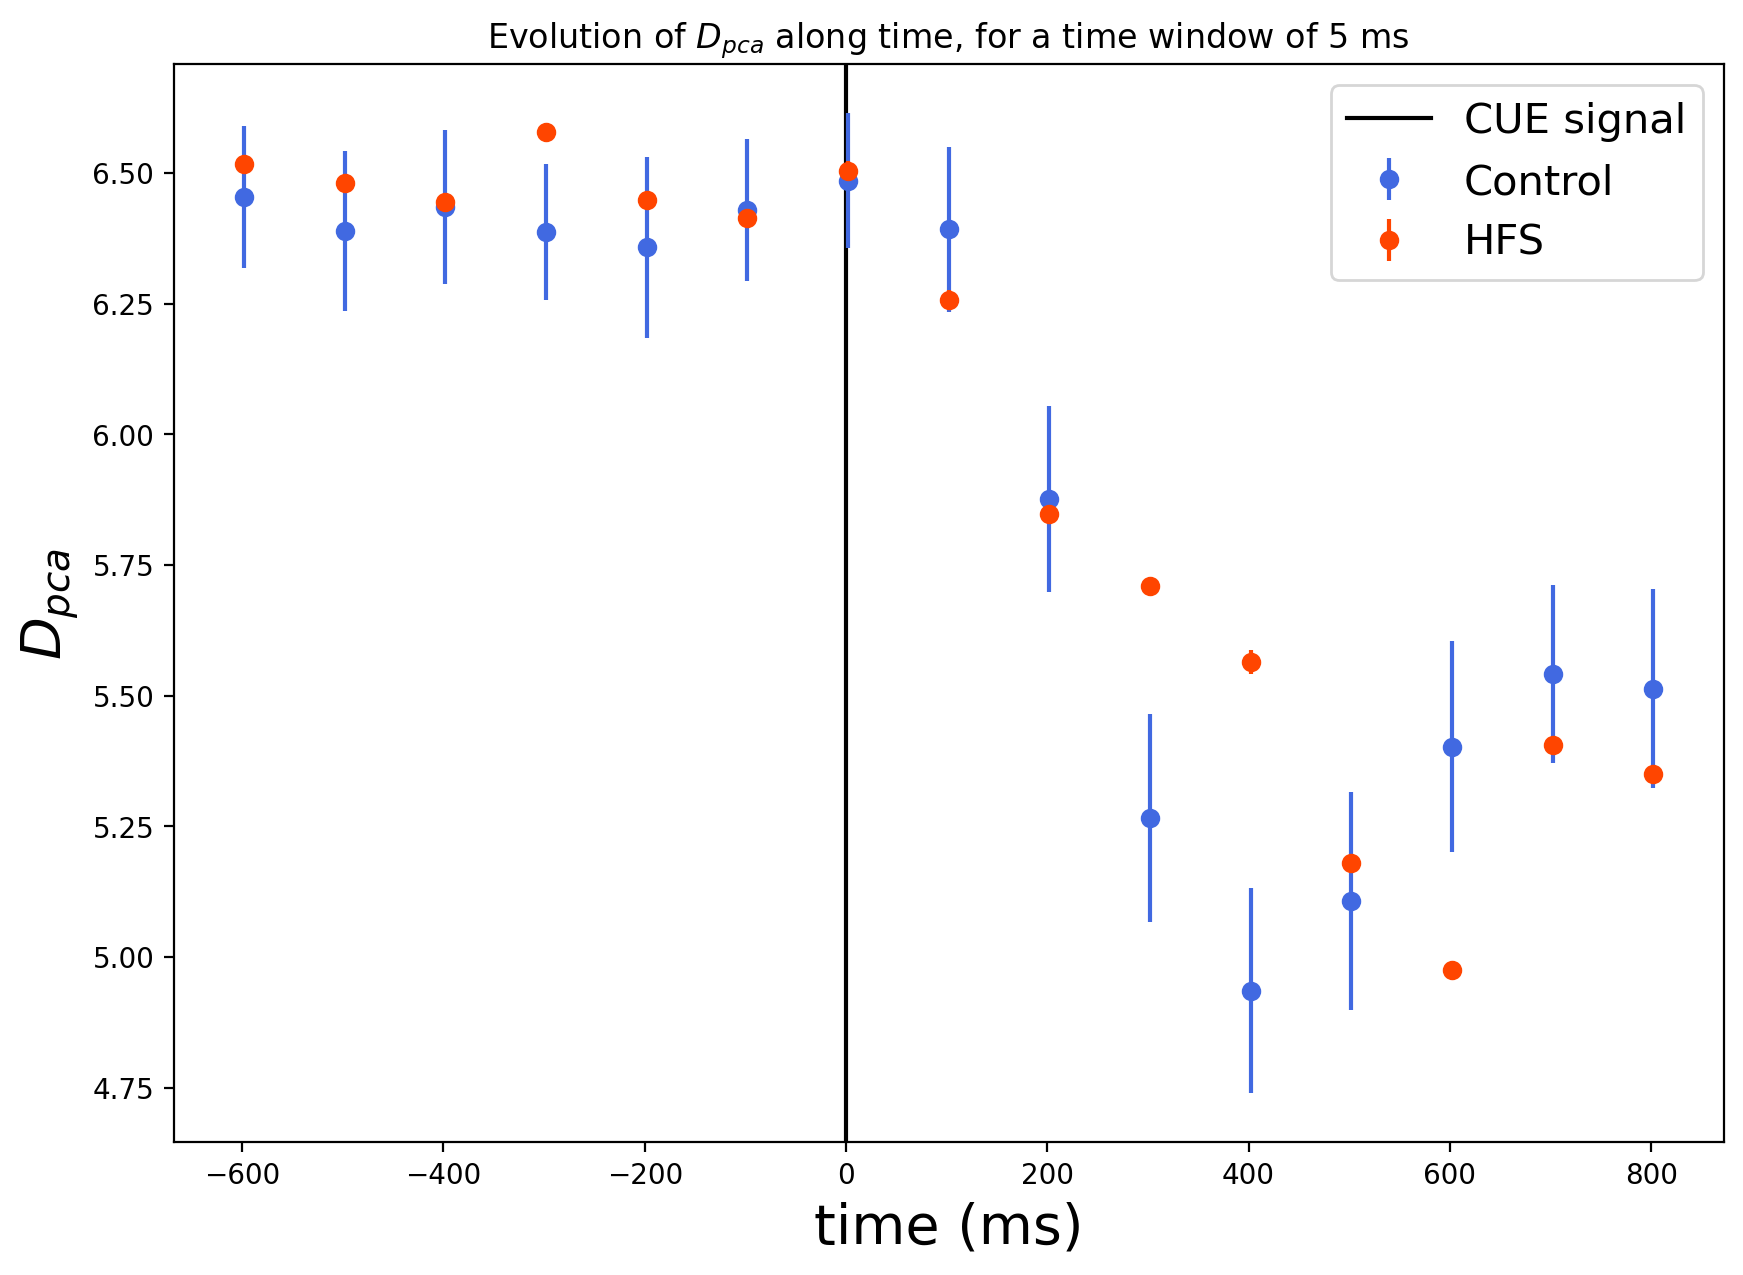

In [28]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_CUE_ws_5_nb_real100_trial_thresh40_sigma100.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label=centering + ' signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

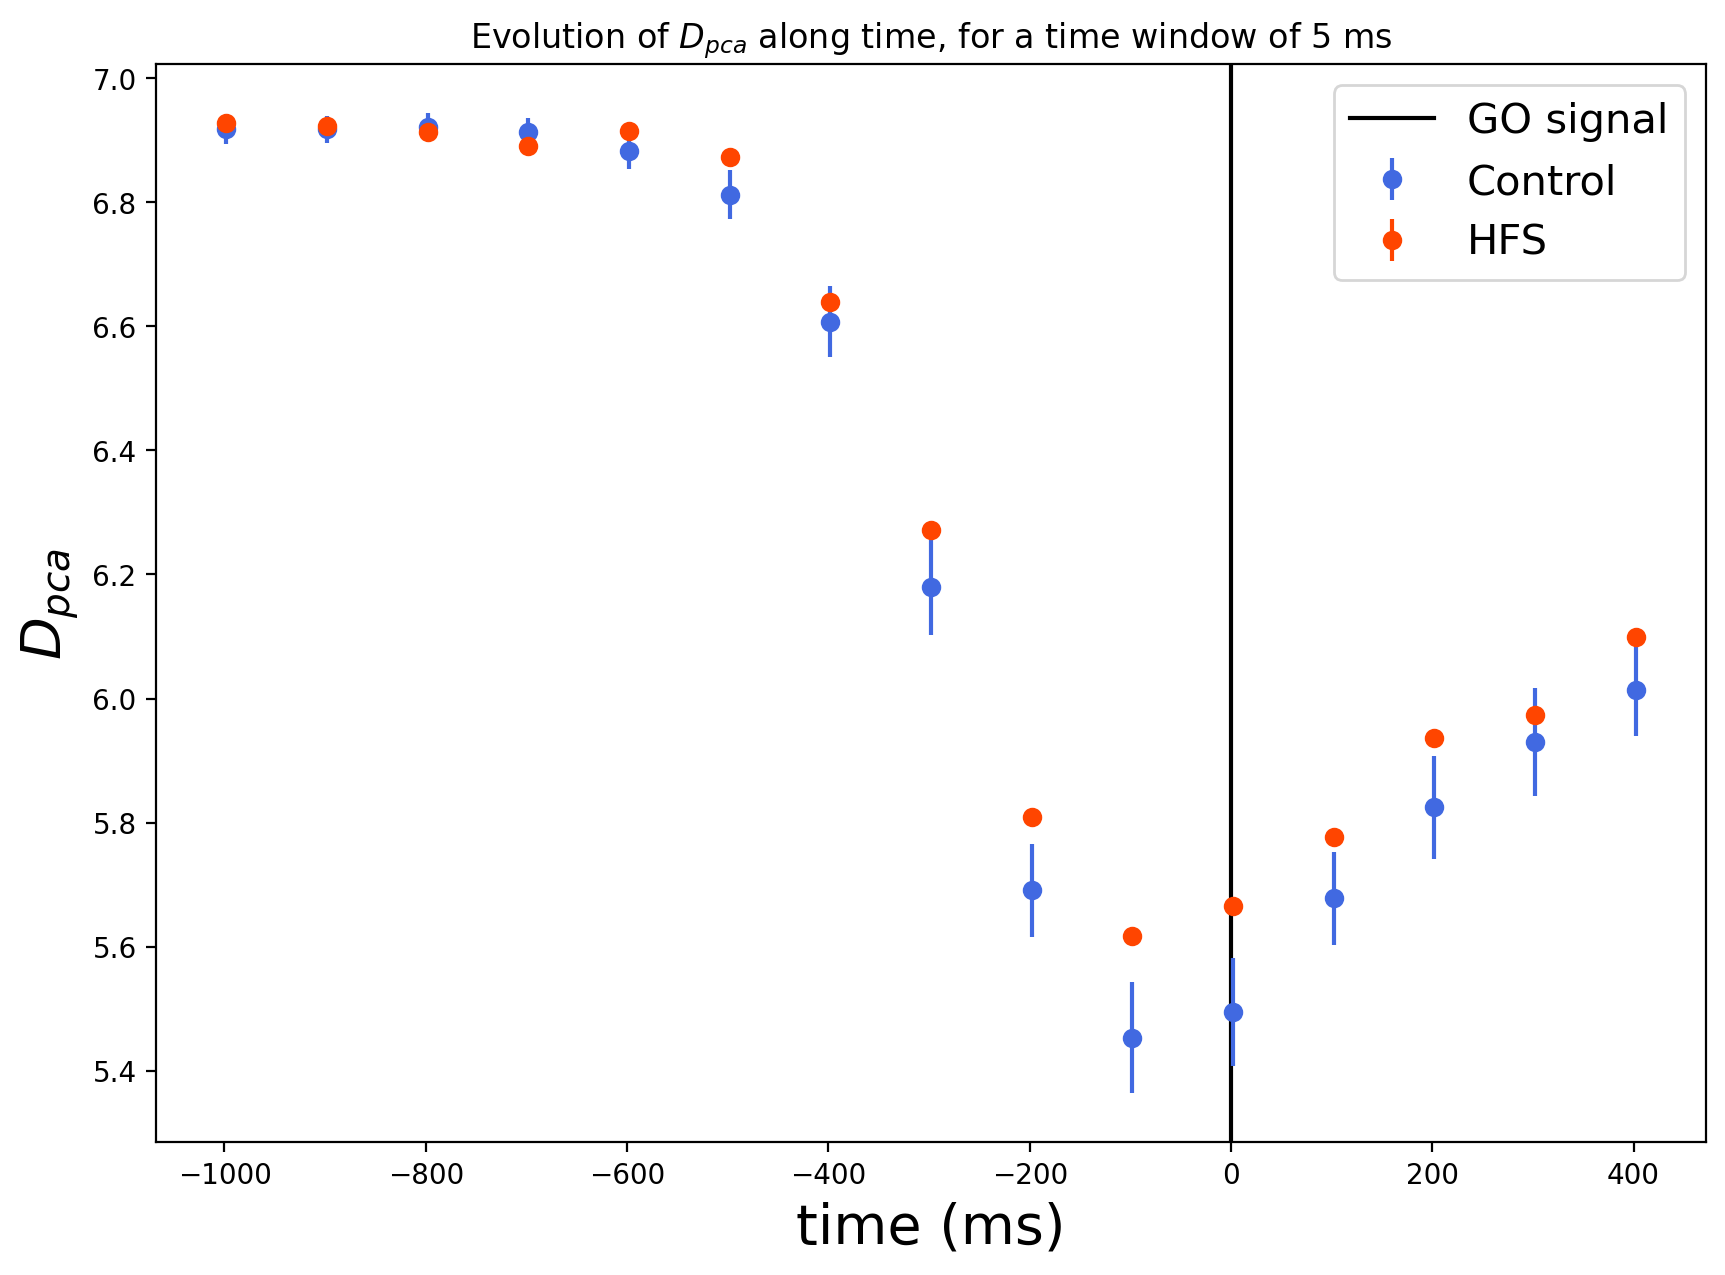

In [341]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_5_nb_real100_trial_thresh0_sigma75.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label='GO signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

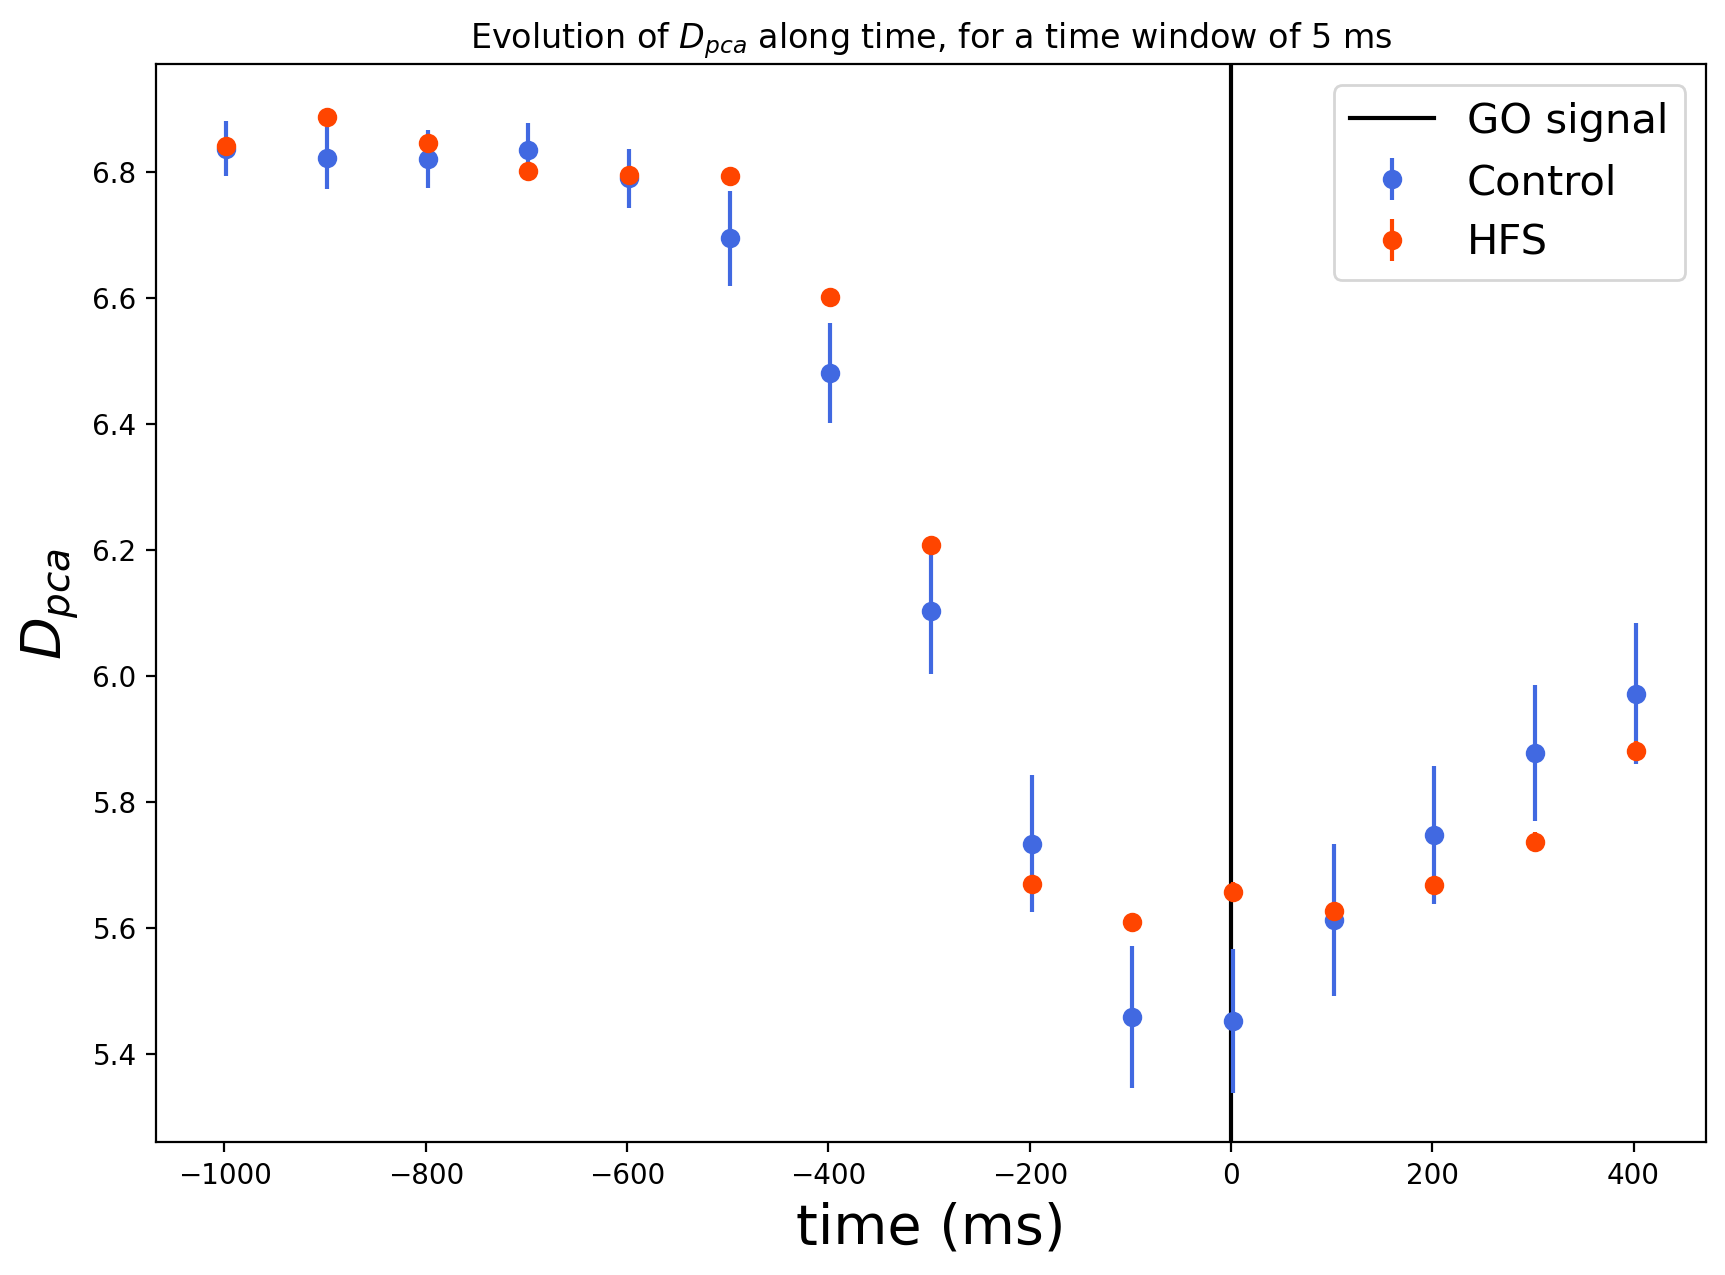

In [331]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_5_nb_real100_trial_thresh30_sigma75.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label='GO signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

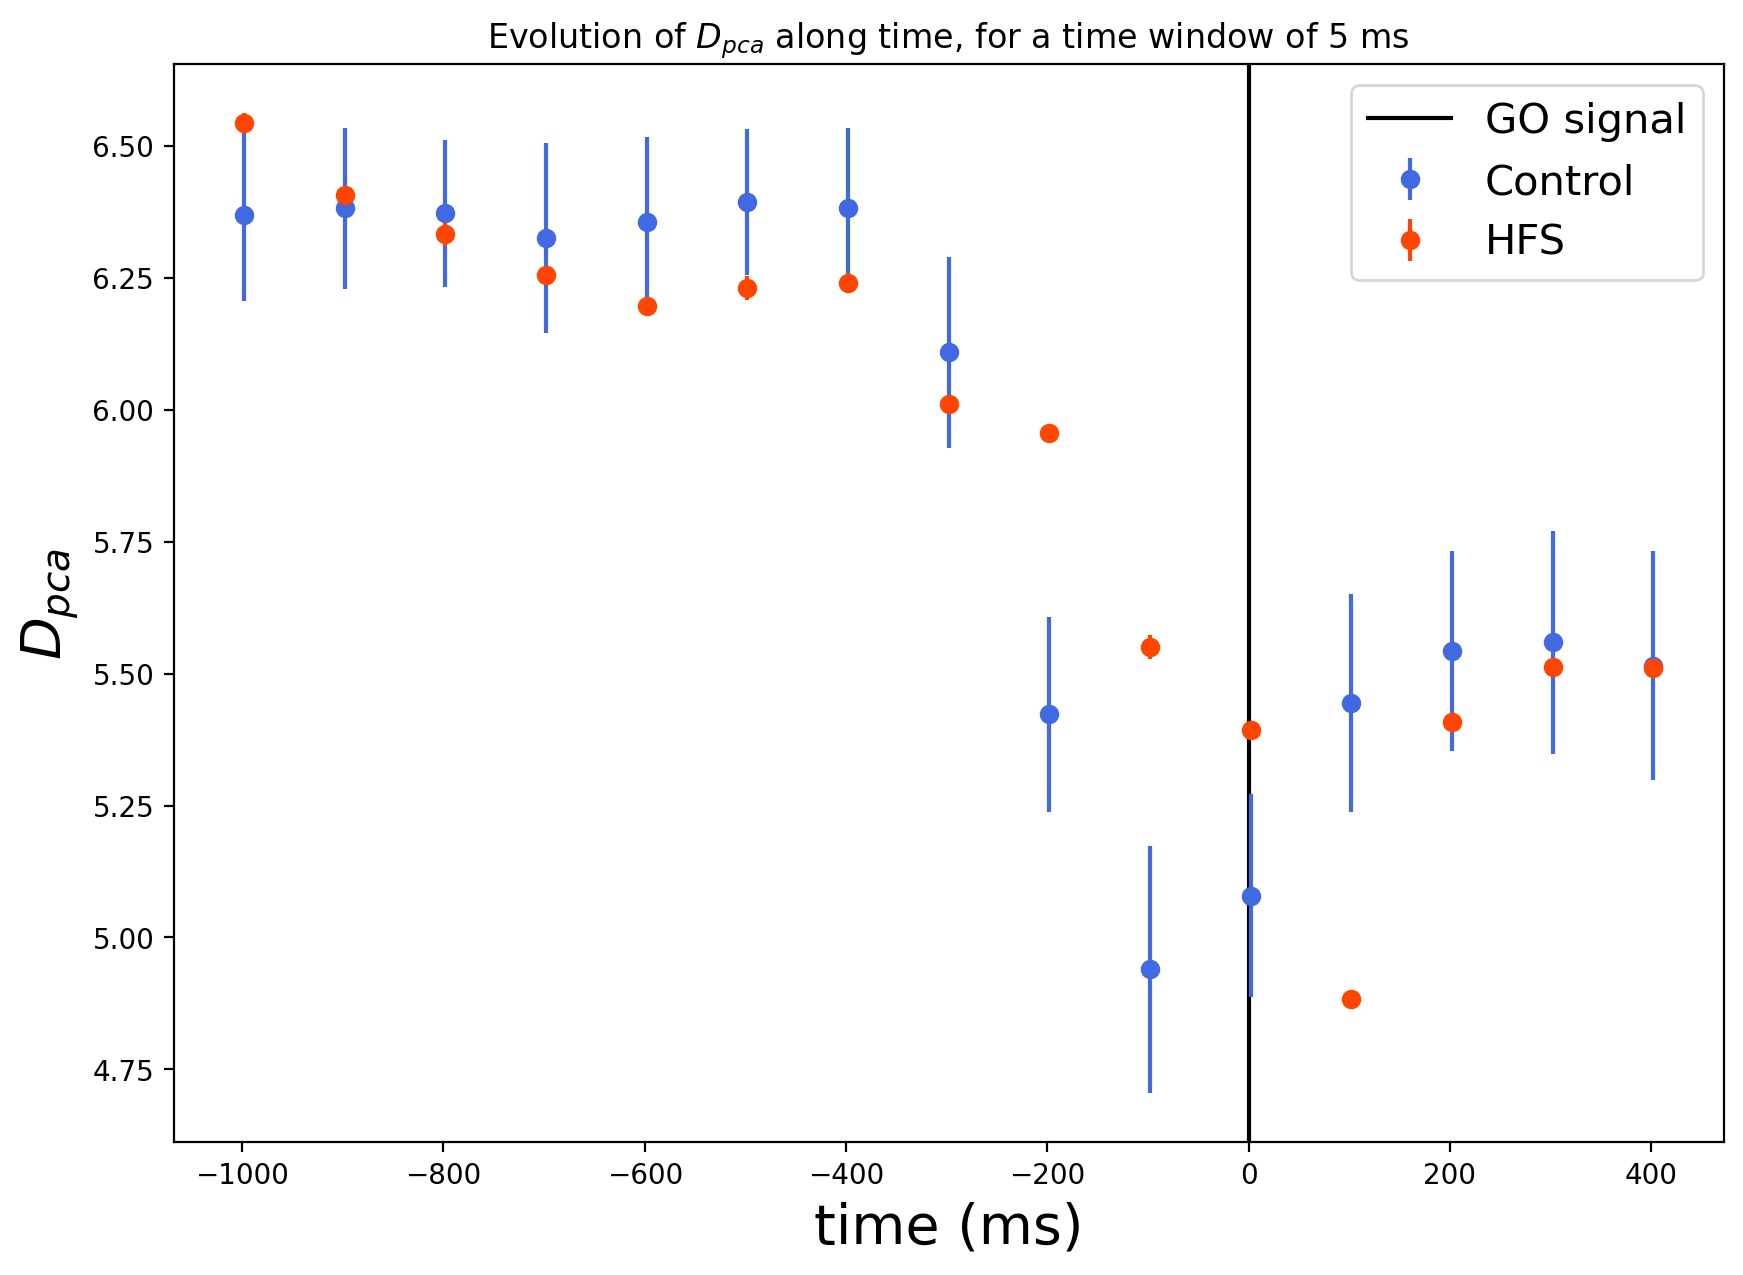

In [308]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_5_nb_real100_trial_thresh40_sigma75.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label='GO signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

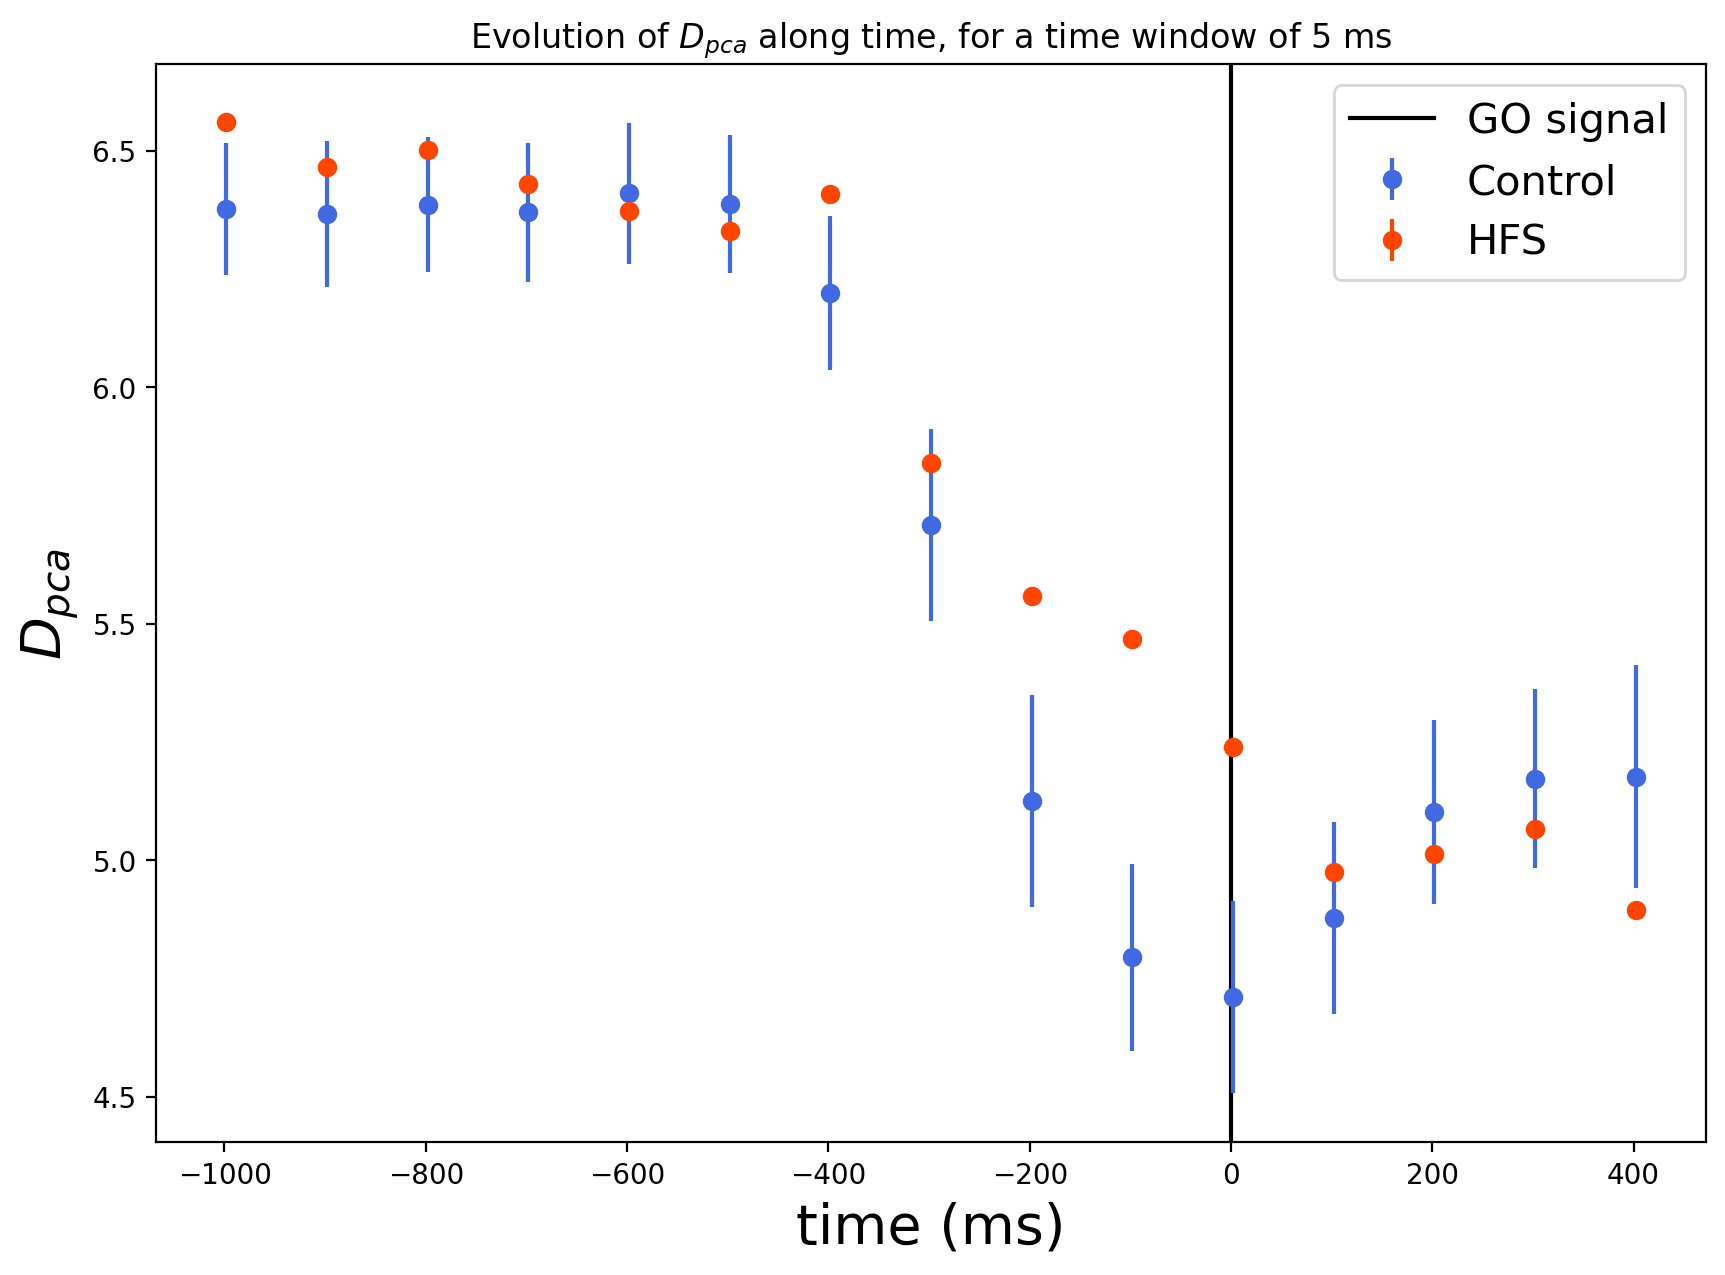

In [279]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_5_nb_real100_trial_thresh40_sigma150.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label='GO signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

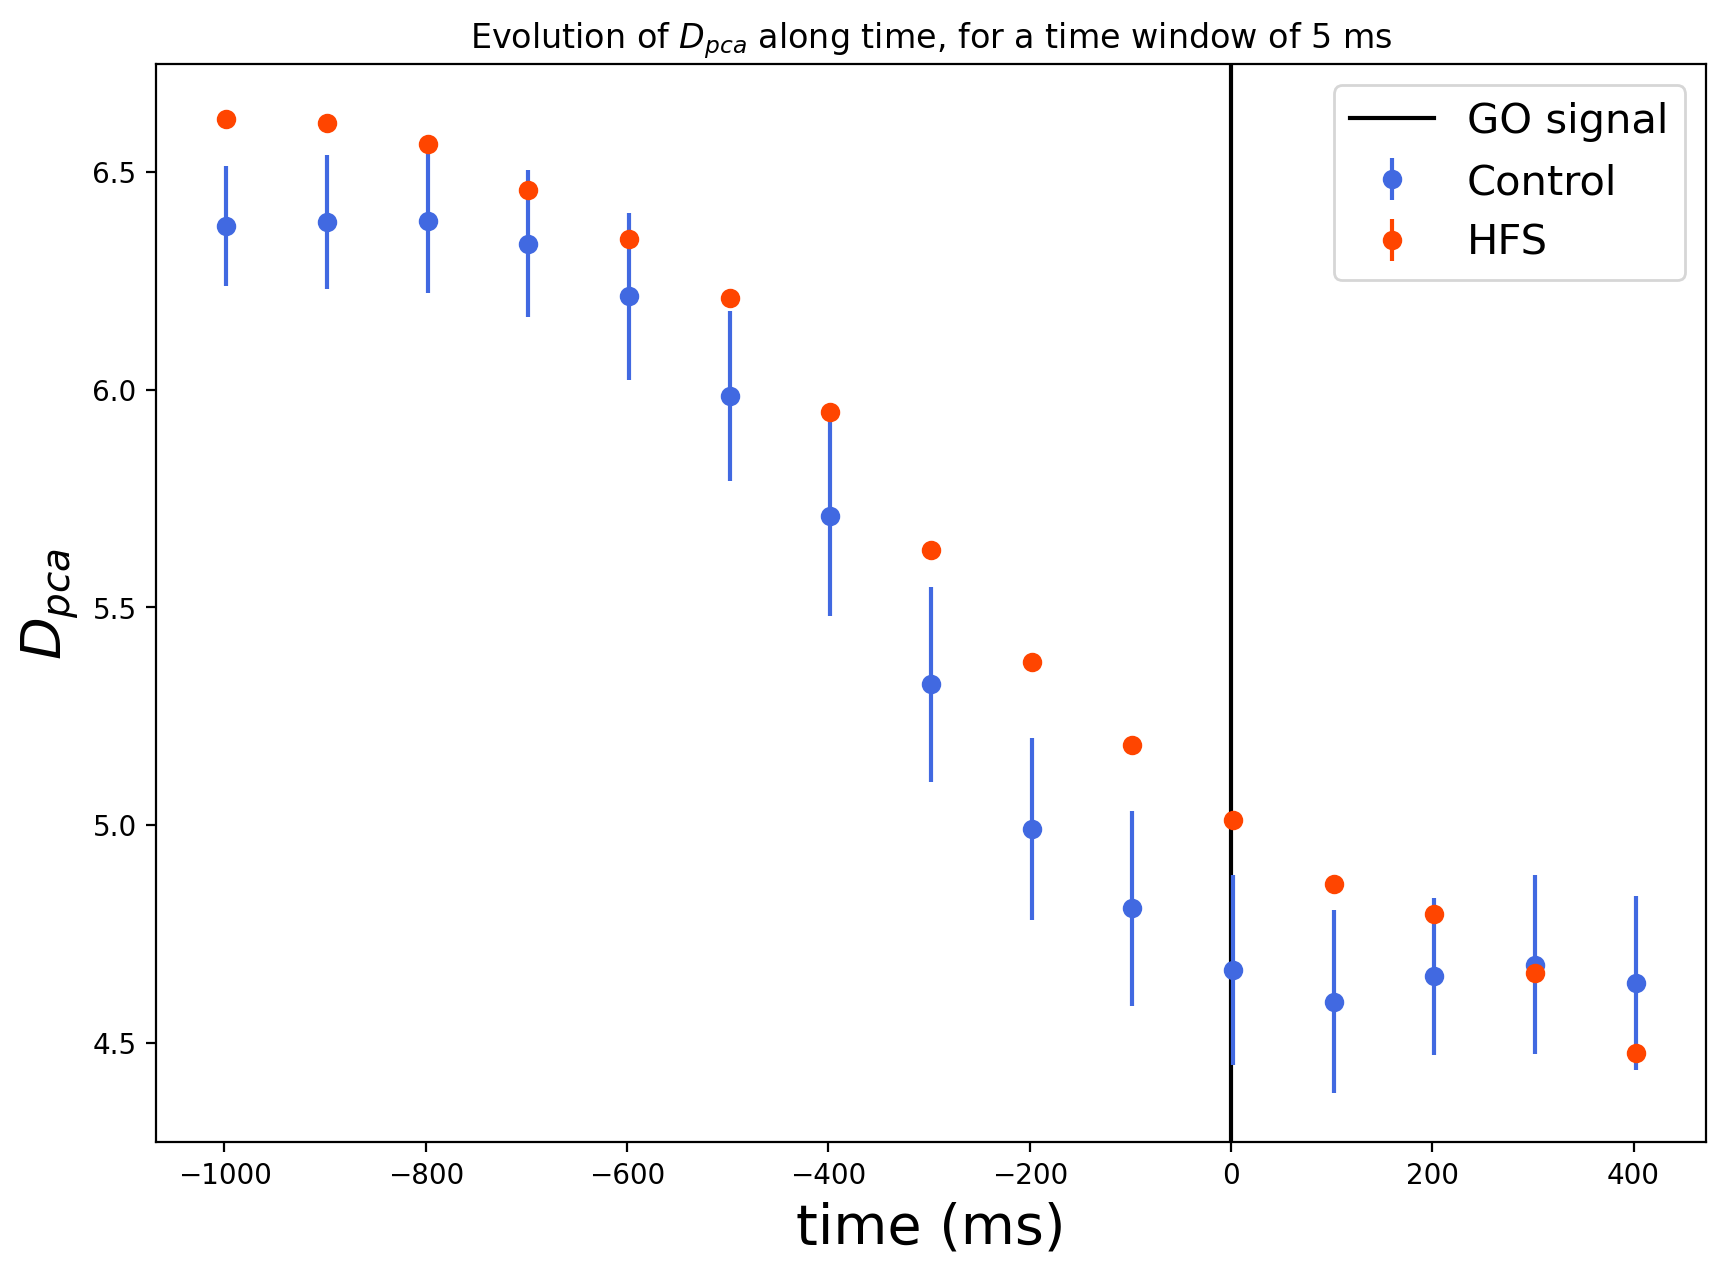

In [243]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_5_nb_real100_trial_thresh40_sigma300.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label='GO signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

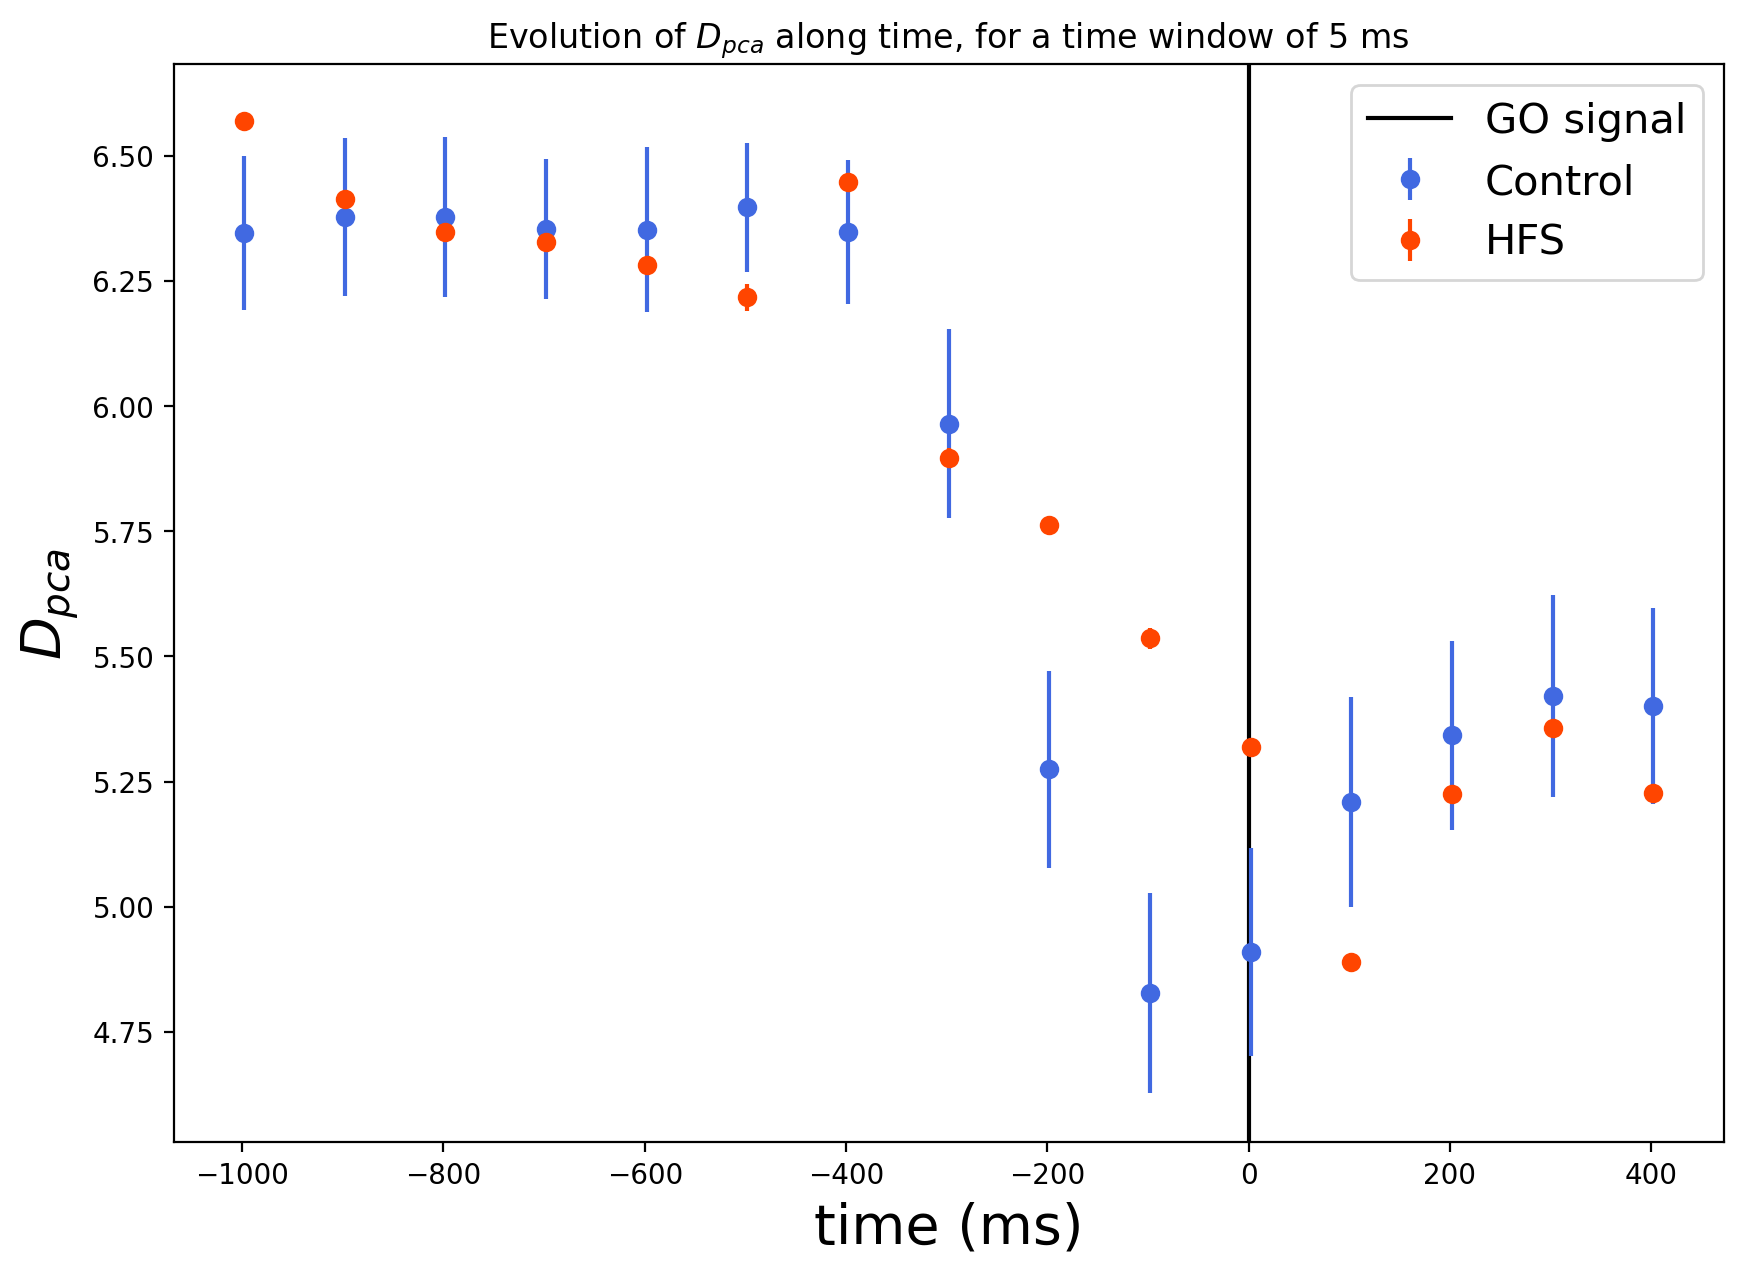

In [244]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_5_nb_real100_trial_thresh40_sigma100.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label='GO signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 5 ms')

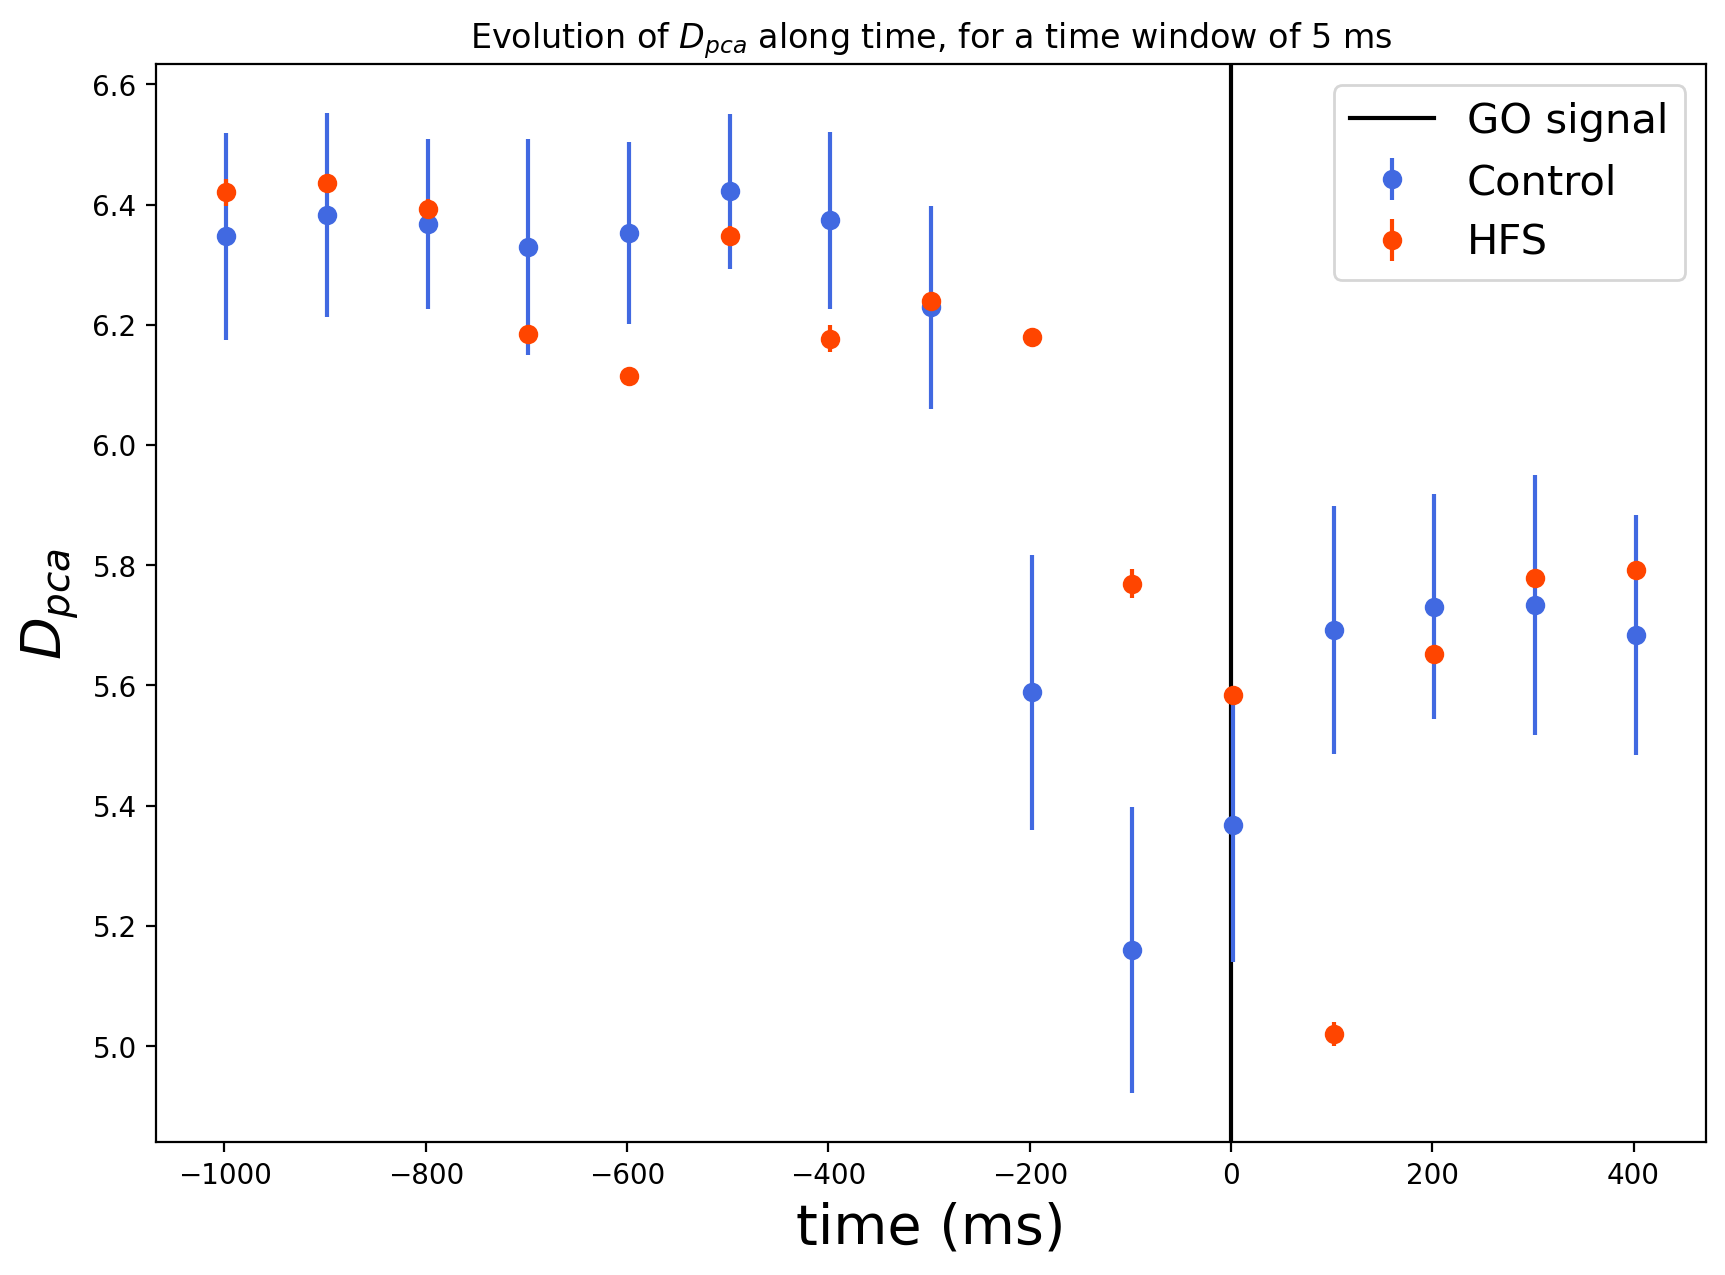

In [191]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_5_nb_real100_trial_thresh40_sigma50.npy')

window_size = 5

plt.figure(figsize = (10,7), dpi = 200)

plt.axvline(0, -1,10, c='k', label='GO signal')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 30 ms')

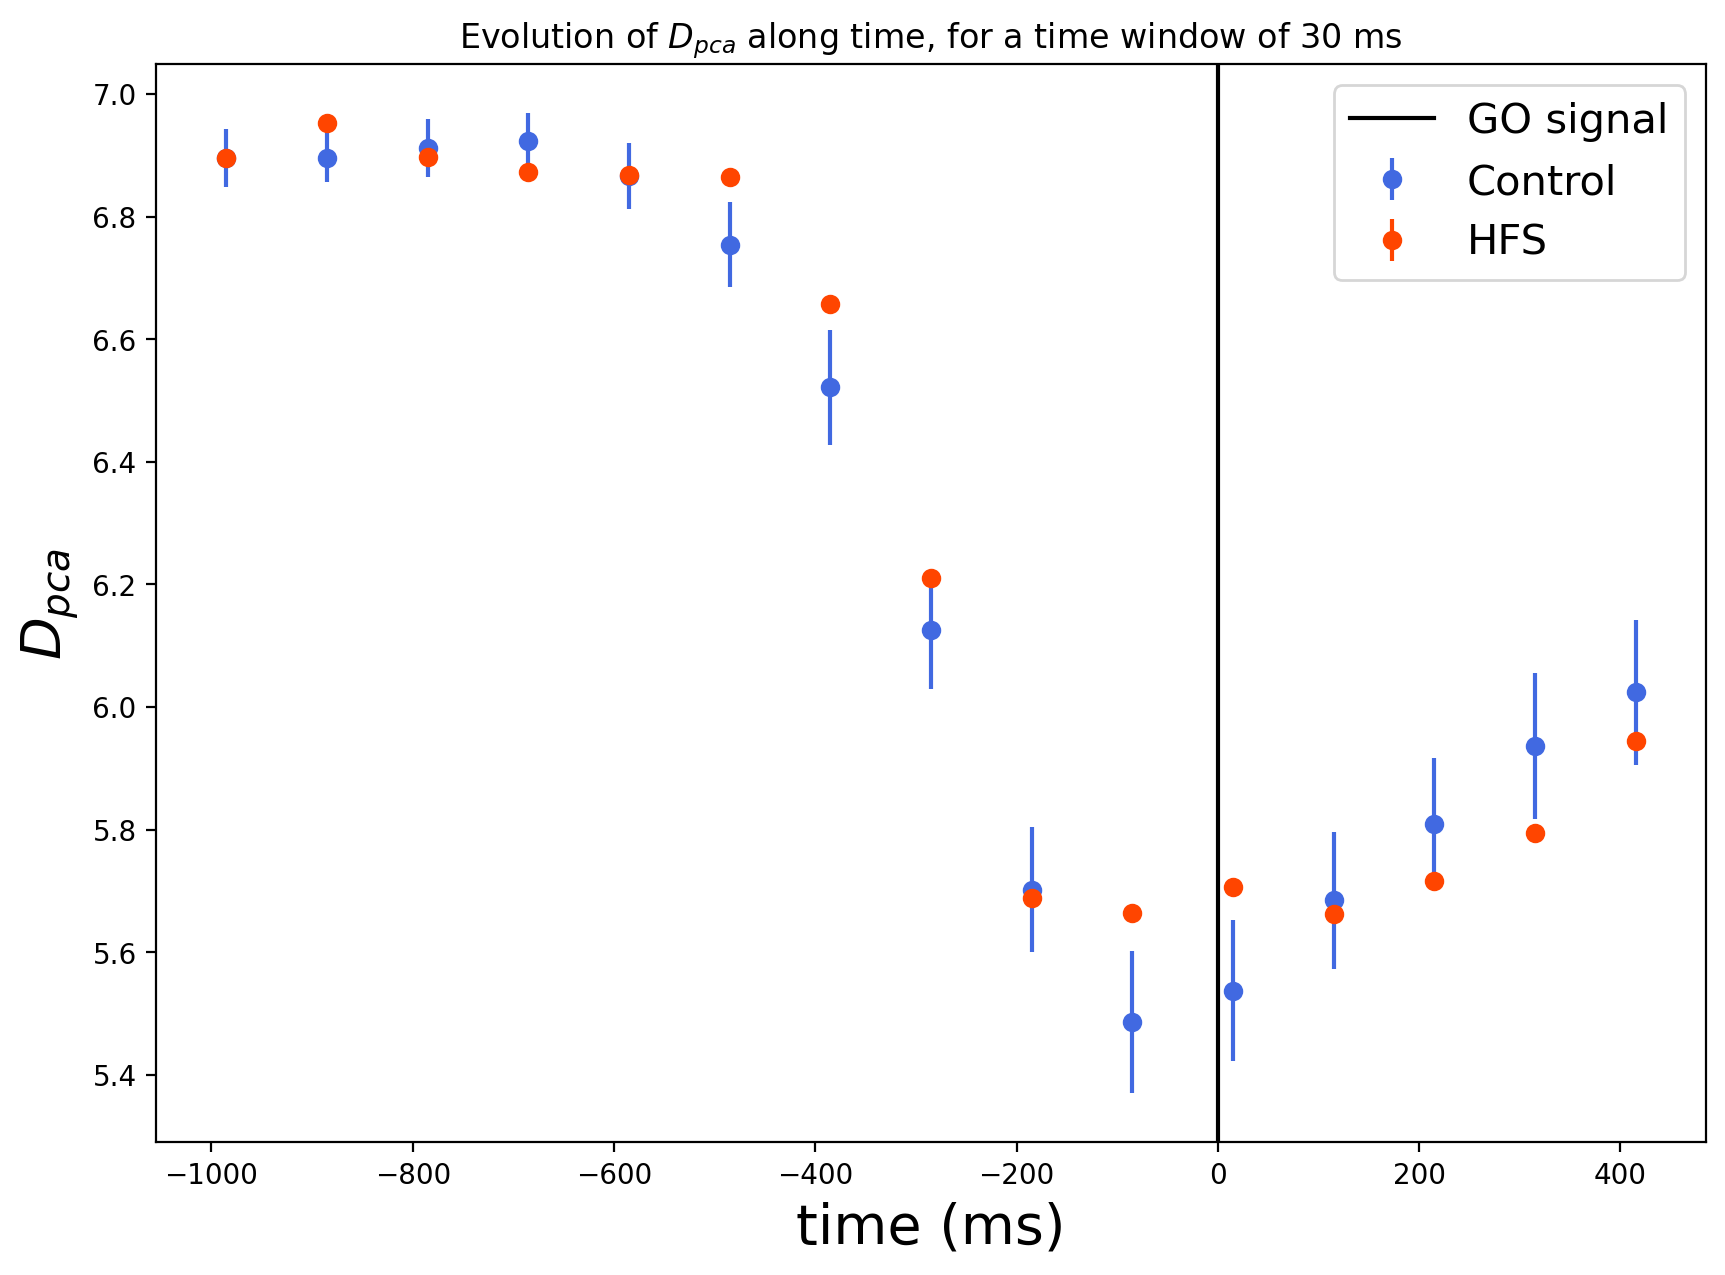

In [535]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_30_nb_real100.npy')

window_size = 30

plt.figure(figsize = (10,7), dpi = 200)

plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.axvline(0, -1,10, c='k', label='GO signal')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)


plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 300 ms')

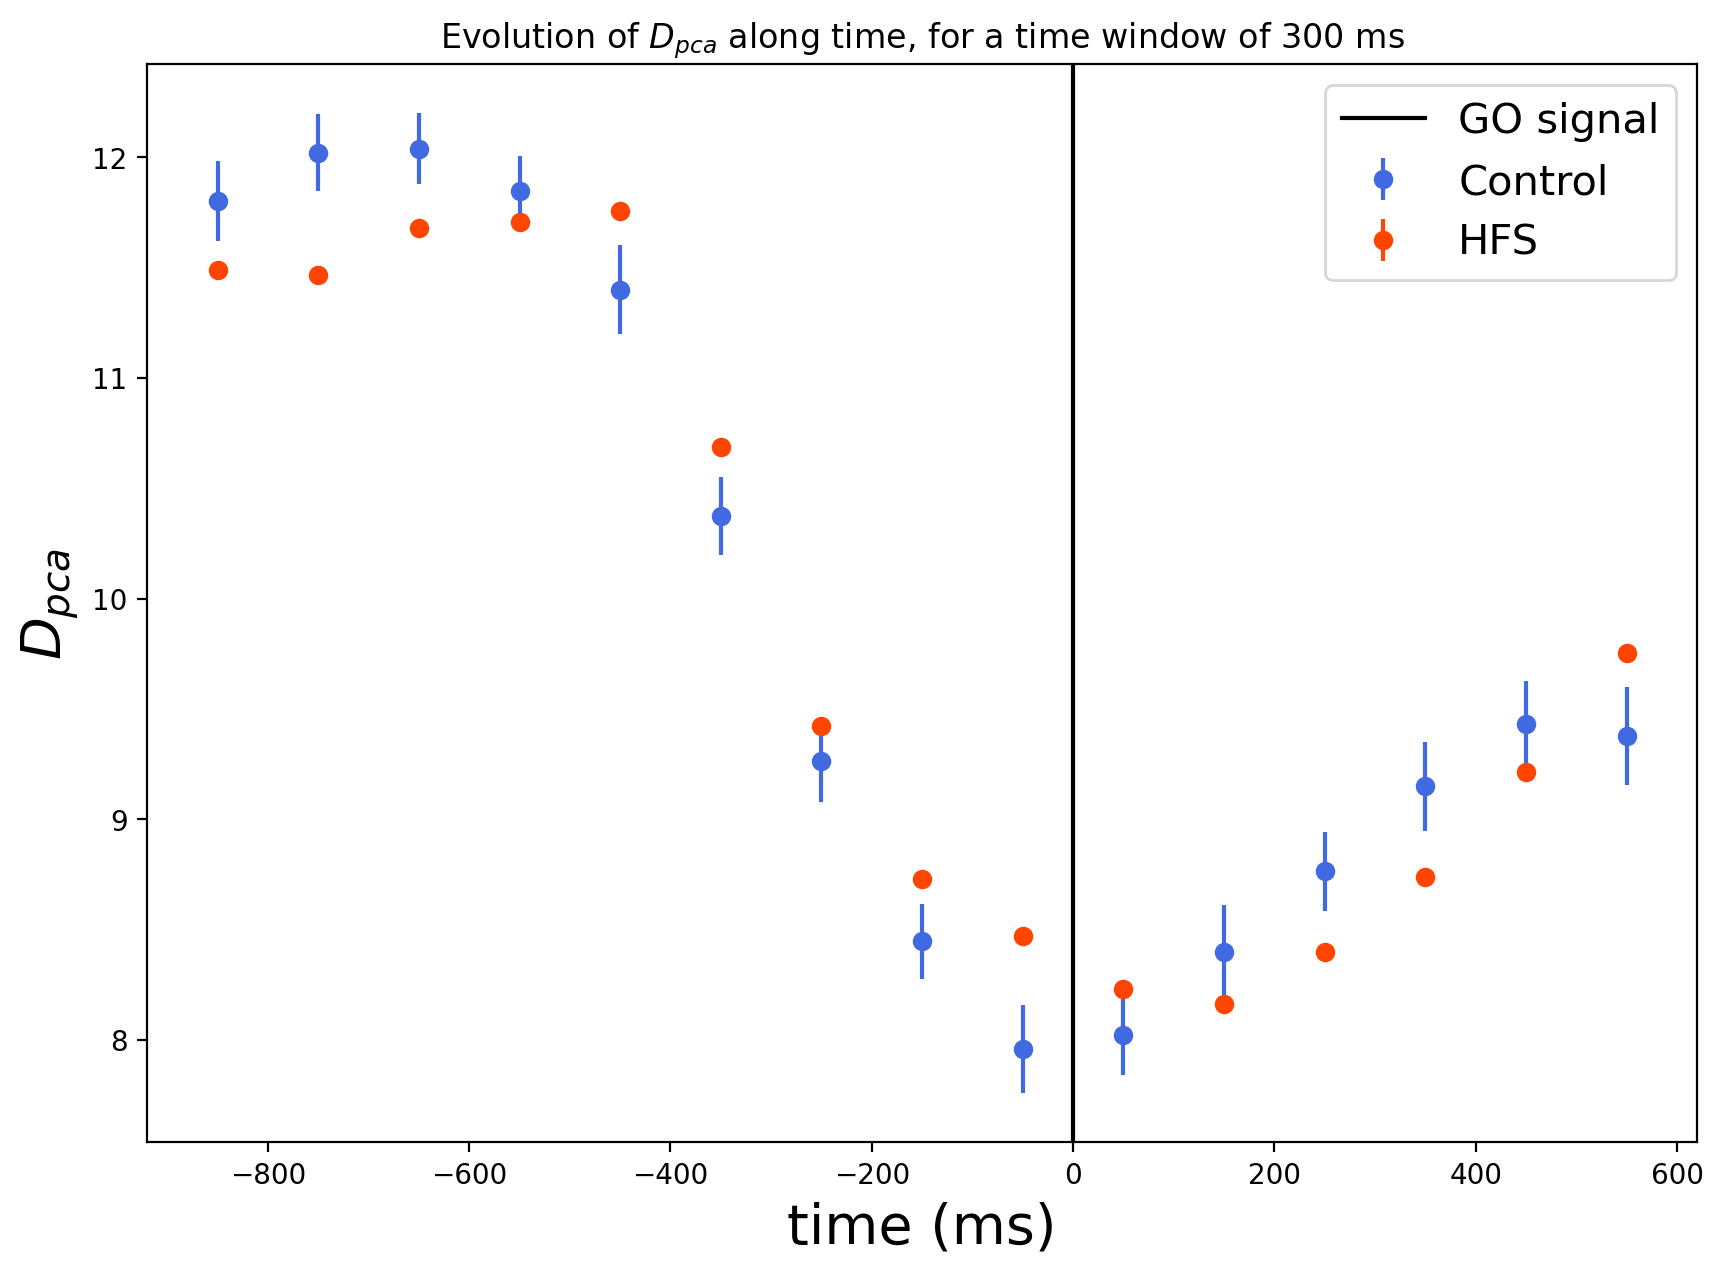

In [536]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_300_nb_real100.npy')

window_size = 300

plt.figure(figsize = (10,7), dpi = 200)

plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.axvline(0, -1,10, c='k', label='GO signal')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)

plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

Text(0.5, 1.0, 'Evolution of $D_{pca}$ along time, for a time window of 600 ms')

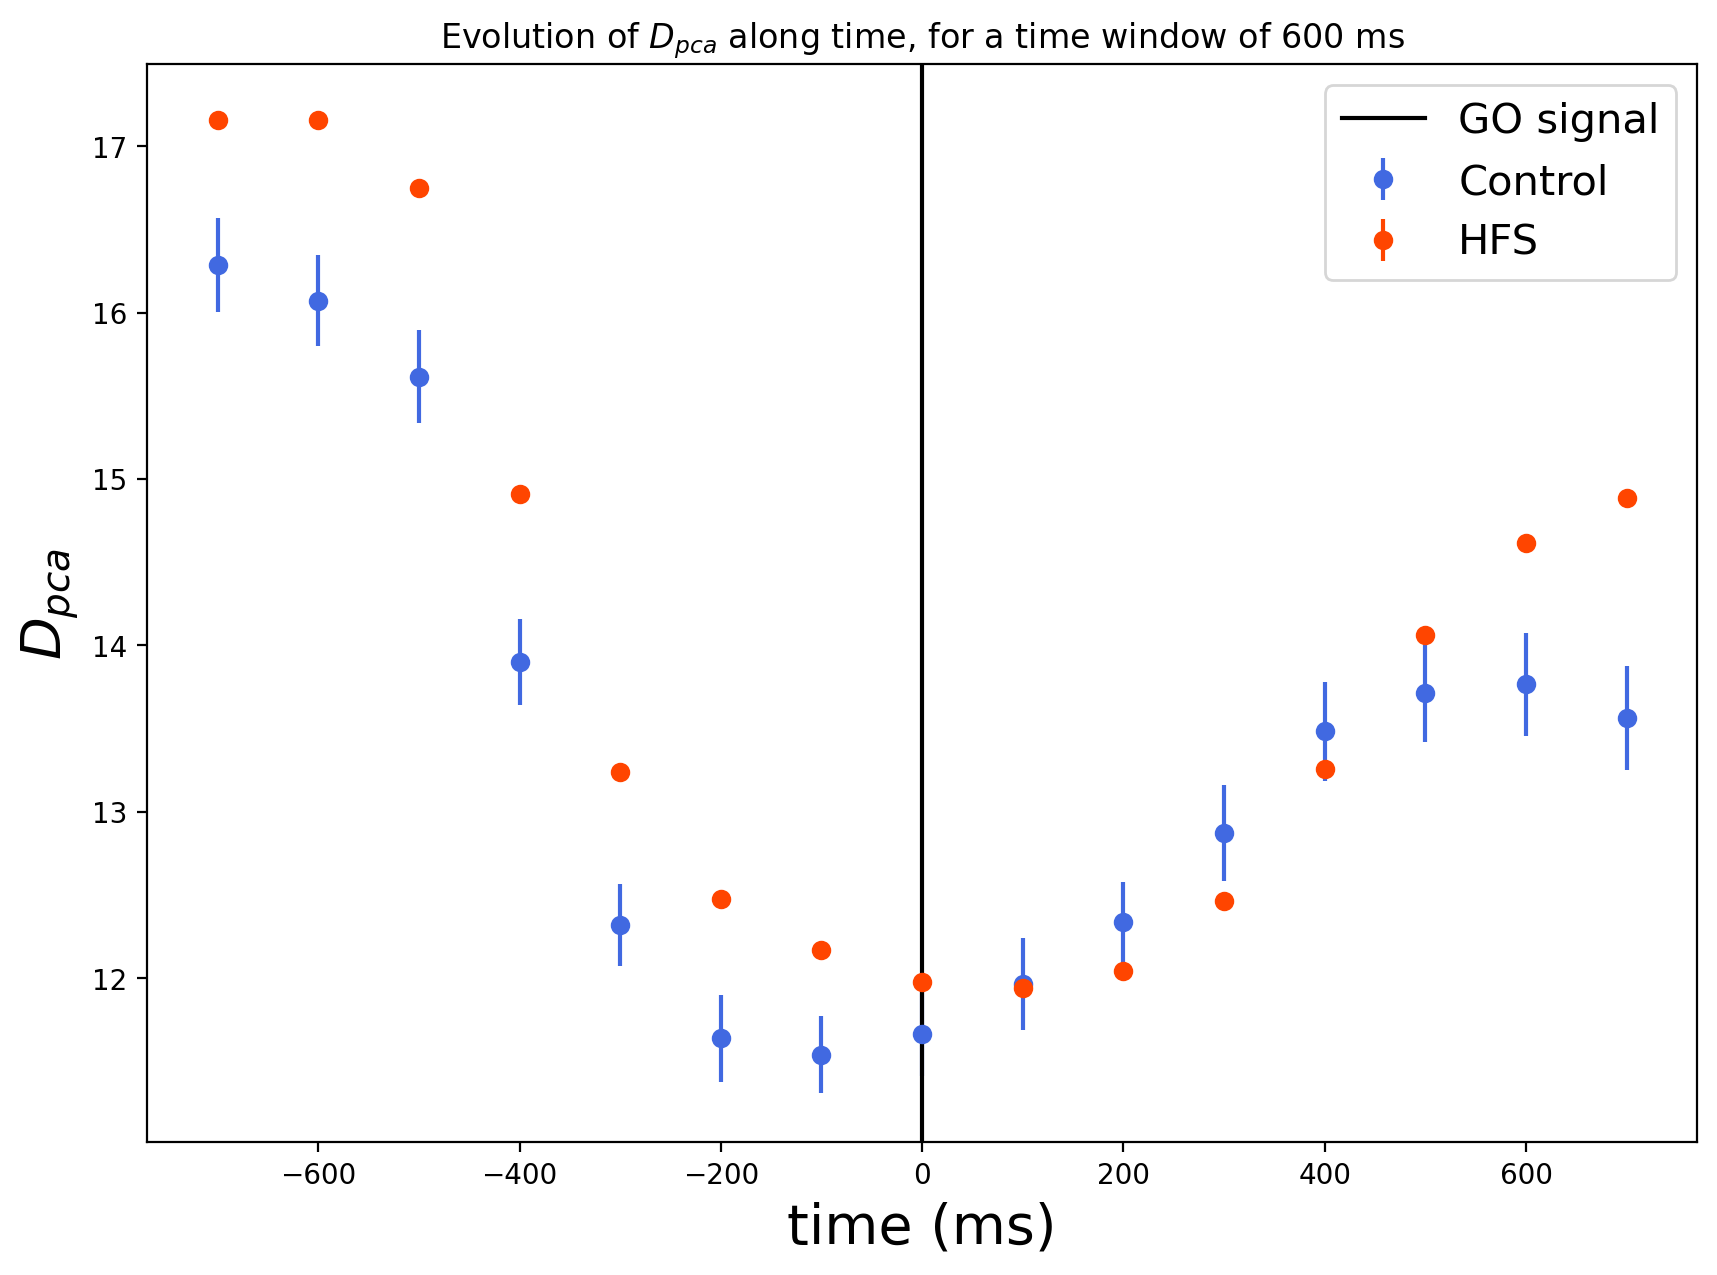

In [537]:
(Dpca_cont_mean, Dpca_cont_std, Dpca_hfs_mean, Dpca_hfs_std, times) = np.load('Dpcas_ws_600_nb_real100.npy')

window_size = 600

plt.figure(figsize = (10,7), dpi = 200)

plt.errorbar(np.array(times)+window_size//2-2000, Dpca_cont_mean, yerr = Dpca_cont_std, fmt = 'o', color ='royalblue', label = 'Control')
plt.errorbar(np.array(times)+window_size//2-2000, Dpca_hfs_mean, yerr = Dpca_hfs_std, fmt = 'o', color ='orangered', label = 'HFS')
plt.axvline(0, -1,10, c='k', label='GO signal')
plt.legend(fontsize = 15)

plt.ylabel('$D_{pca}$', fontsize = 20)
plt.xlabel('time (ms)', fontsize = 20)

plt.title('Evolution of $D_{pca}$ along time, for a time window of %s ms'%window_size)

# Putting on the same figure Dpcas computed for different alignments 

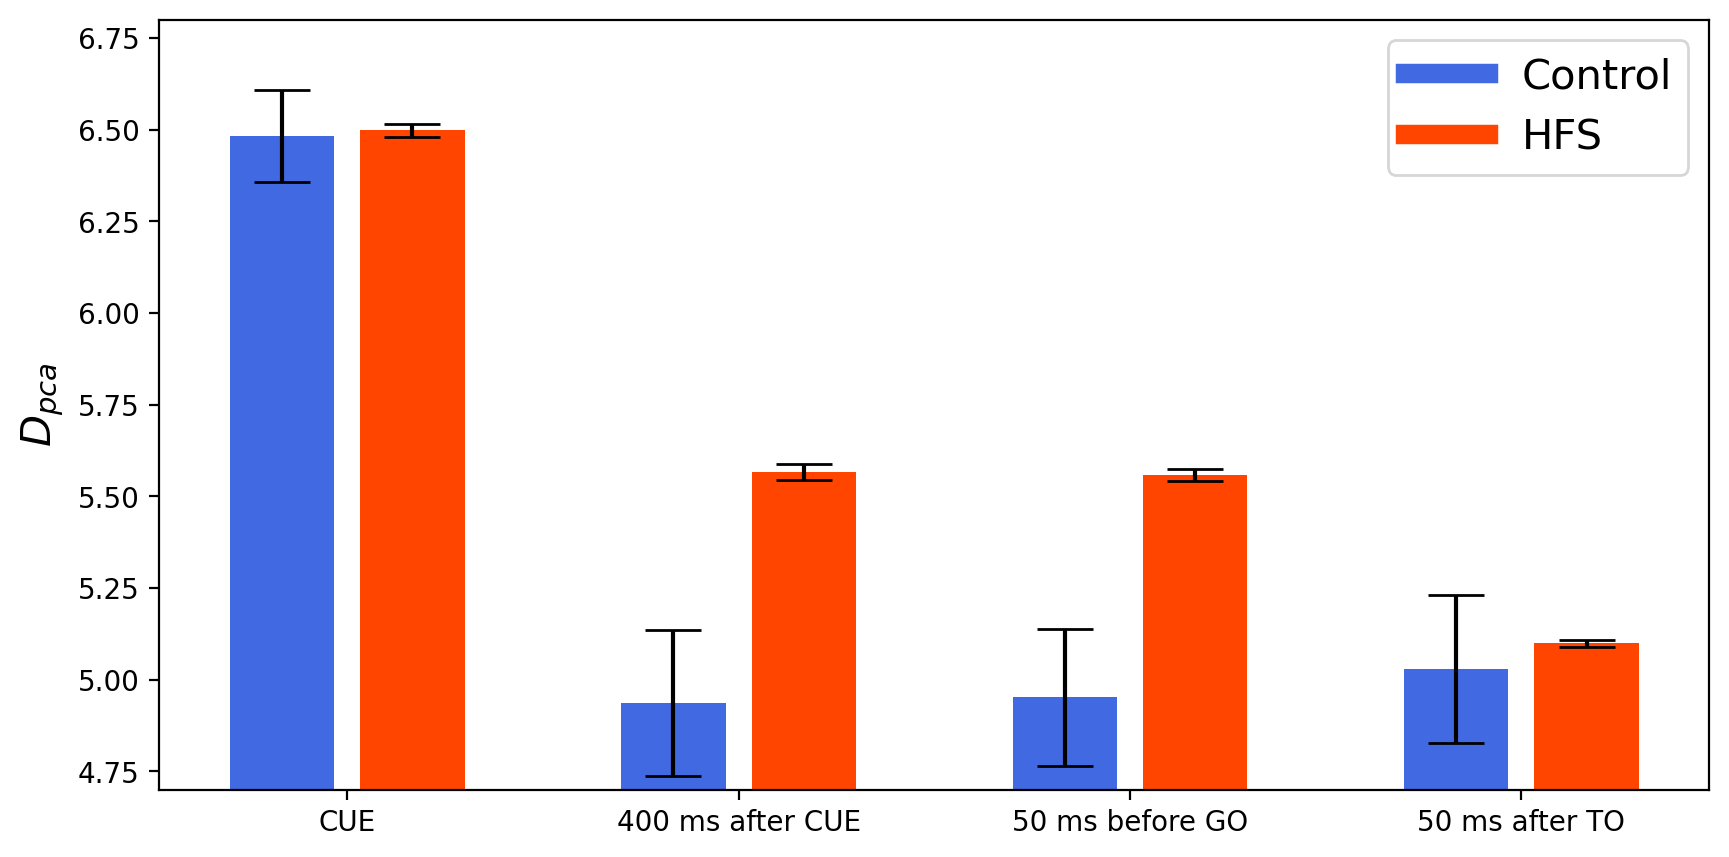

In [16]:

(Dpca_cont_mean_cue, Dpca_cont_std_cue, Dpca_hfs_mean_cue, Dpca_hfs_std_cue, times_cue) = np.load('Dpcas_CUE_ws_5_nb_real100_trial_thresh40_sigma100.npy')
(Dpca_cont_mean_go, Dpca_cont_std_go, Dpca_hfs_mean_go, Dpca_hfs_std_go, times_go) = np.load('Dpcas_GO_ws_5_nb_real100_trial_thresh40_sigma100.npy')
(Dpca_cont_mean_to, Dpca_cont_std_to, Dpca_hfs_mean_to, Dpca_hfs_std_to, times_to) = np.load('Dpcas_TO_ws_5_nb_real100_trial_thresh40_sigma100.npy')

fig, ax = plt.subplots(figsize = (10,5), dpi = 200)

xpos = np.array([-0.5,0.5])

colors = ['royalblue', 'orangered']

cue_ind = np.where(times_cue==2000)[0][0]
cue_ind_400 = np.where(times_cue==2400)[0][0]
go_ind = np.where(times_go==1950)[0][0]
to_ind = np.where(times_to==2050)[0][0]


Y_cue = [Dpca_cont_mean_cue[cue_ind], Dpca_hfs_mean_cue[cue_ind]]
Yerr_cue = [Dpca_cont_std_cue[cue_ind], Dpca_hfs_std_cue[cue_ind]]

Y_cue_400 = [Dpca_cont_mean_cue[cue_ind_400], Dpca_hfs_mean_cue[cue_ind_400]]
Yerr_cue_400 = [Dpca_cont_std_cue[cue_ind_400], Dpca_hfs_std_cue[cue_ind_400]]

Y_go = [Dpca_cont_mean_go[go_ind], Dpca_hfs_mean_go[go_ind]]
Yerr_go = [Dpca_cont_std_go[go_ind], Dpca_hfs_std_go[go_ind]]

Y_to = [Dpca_cont_mean_to[to_ind], Dpca_hfs_mean_to[to_ind]]
Yerr_to = [Dpca_cont_std_to[to_ind], Dpca_hfs_std_to[to_ind]]


ax.bar(xpos, Y_cue , yerr = Yerr_cue, capsize = 10, color = colors, label = ['cont', 'HFS'])
ax.bar(xpos+3, Y_cue_400 , yerr = Yerr_cue_400, capsize = 10, color = colors)
ax.bar(xpos+6, Y_go , yerr = Yerr_go, capsize = 10, color = colors)
ax.bar(xpos+9, Y_to , yerr = Yerr_to, capsize = 10, color = colors)



legend_elements = [Line2D([0], [0], color='royalblue', lw = 7 ,label='Control'),
                   Line2D([0], [0], color='orangered', lw = 7,label='HFS')]
ax.legend(handles = legend_elements, fontsize = 15)

ax.set_ylim((4.7,6.8))
ax.set_ylabel('$D_{pca}$', fontsize = 15)

ax.set_xticks([0,3,6,9])
ax.set_xticklabels(['CUE','400 ms after CUE','50 ms before GO','50 ms after TO'])

#plt.savefig('Dpca_cont8_HFS8_cue_go_to.pdf' , transparent=True, bbox_inches="tight")

# Drawing the neural states

In [20]:
# Load the data from the .npy files

centering = 'GO'

dic_cont8 = get_data('dic_cont8_'+centering+'.npy')
dic_hfs = get_data('dic_hfs_'+centering+'.npy')
dic_tot = get_data('dic_tot_'+centering+'.npy')

# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)
dic_hfs = smoothen_data(dic_hfs, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]
    
nb_trials_hfs = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_hfs[i] = dic_hfs['target'][i].shape[0]
    
number_of_trials_to_consider = np.min([nb_trials_hfs, nb_trials_cont8], axis = 0).astype('int')

In [68]:
t= 1900
window_size = 150
hfs_trial_thresh = 0

np.random.seed(seed = 12345678)

# radomly select trial indices
(trial_indices_to_consider_cont8, trial_indices_to_consider_hfs) = get_rand_tr_indices_same_nbt_per_target(dic_cont8, dic_hfs)

# Add trial-averaged data to the dictionaries and return the neuron filter that has entry 1 if there is at least one recording per target
# for this neuron
(dic_cont8, neuron_filter_cont8) = add_condition_average_to_dic_with_defined_trials(dic_cont8, trial_indices_to_consider_cont8)
(dic_hfs, neuron_filter_hfs) = add_condition_average_to_dic_with_defined_trials(dic_hfs, trial_indices_to_consider_hfs)

# Compute the final neuron filter as the element-wise product of the neuron filters obtained from the two datasets
neuron_filter = neuron_filter_cont8 * neuron_filter_hfs 


# Add to this the fact that we want only half of the hfs neurons with the maximal number of trials
neuron_filter_many_trials = (nb_trials_hfs >= hfs_trial_thresh)
neuron_filter *= neuron_filter_many_trials

## ADD THE ZSCORED MATRICES BASED ON THIS NEURON FILTER AND SELECTED TRIALS
# Get the number of neurons from a previously defined filter
nb_neurons = neuron_filter.shape[0]

# Create an empty list in the dictionary "dic_tot" to store the concatenated matrices
dic_tot['mat_cond_avg'] = []

# Loop through each neuron
for neuron in range(nb_neurons):
    # Concatenate the matrices for the same neuron from the control8 and HFS8 dictionaries
    res = np.concatenate((dic_cont8['mat_cond_avg'][neuron] , dic_hfs['mat_cond_avg'][neuron]), axis = 0 )

    # Add the concatenated matrix to the list in the "dic_tot" dictionary
    dic_tot['mat_cond_avg'].append(res)

# Add z-scored matrices to each of the three dictionaries using the "add_zscored_to_dic" function
# The matrices will be based on a time window of 300 time steps centered around time step 1850
# The "test_set" argument is set to False
dic_tot = add_zscored_to_dic(dic_tot, t, window_size, test_set = False)
dic_cont8 = add_zscored_to_dic(dic_cont8, t, window_size, test_set = False)
dic_hfs = add_zscored_to_dic(dic_hfs, t, window_size, test_set = False)

## DO THE PCAs
eigvals, eigvects, eigvals_cont, eigvects_cont, eigvals_hfs, eigvects_hfs = perform_PCAs(dic_tot, dic_cont8, dic_hfs, neuron_filter, t, window_size)


In [69]:
z_scored_data = dic_tot['mat_zscored']
z_scored_data_cont8 = dic_cont8['mat_zscored']
z_scored_data_hfs = dic_hfs['mat_zscored']

Npca = 10
neur_states = np.zeros((16,4001,Npca))
for npc in range(Npca):
    neur_states[:,:,npc] = (np.array(z_scored_data)[neuron_filter,:,:].transpose()@eigvects[:,-(npc+1)]).transpose()
    
#neur_states[:,:,5] *= -1

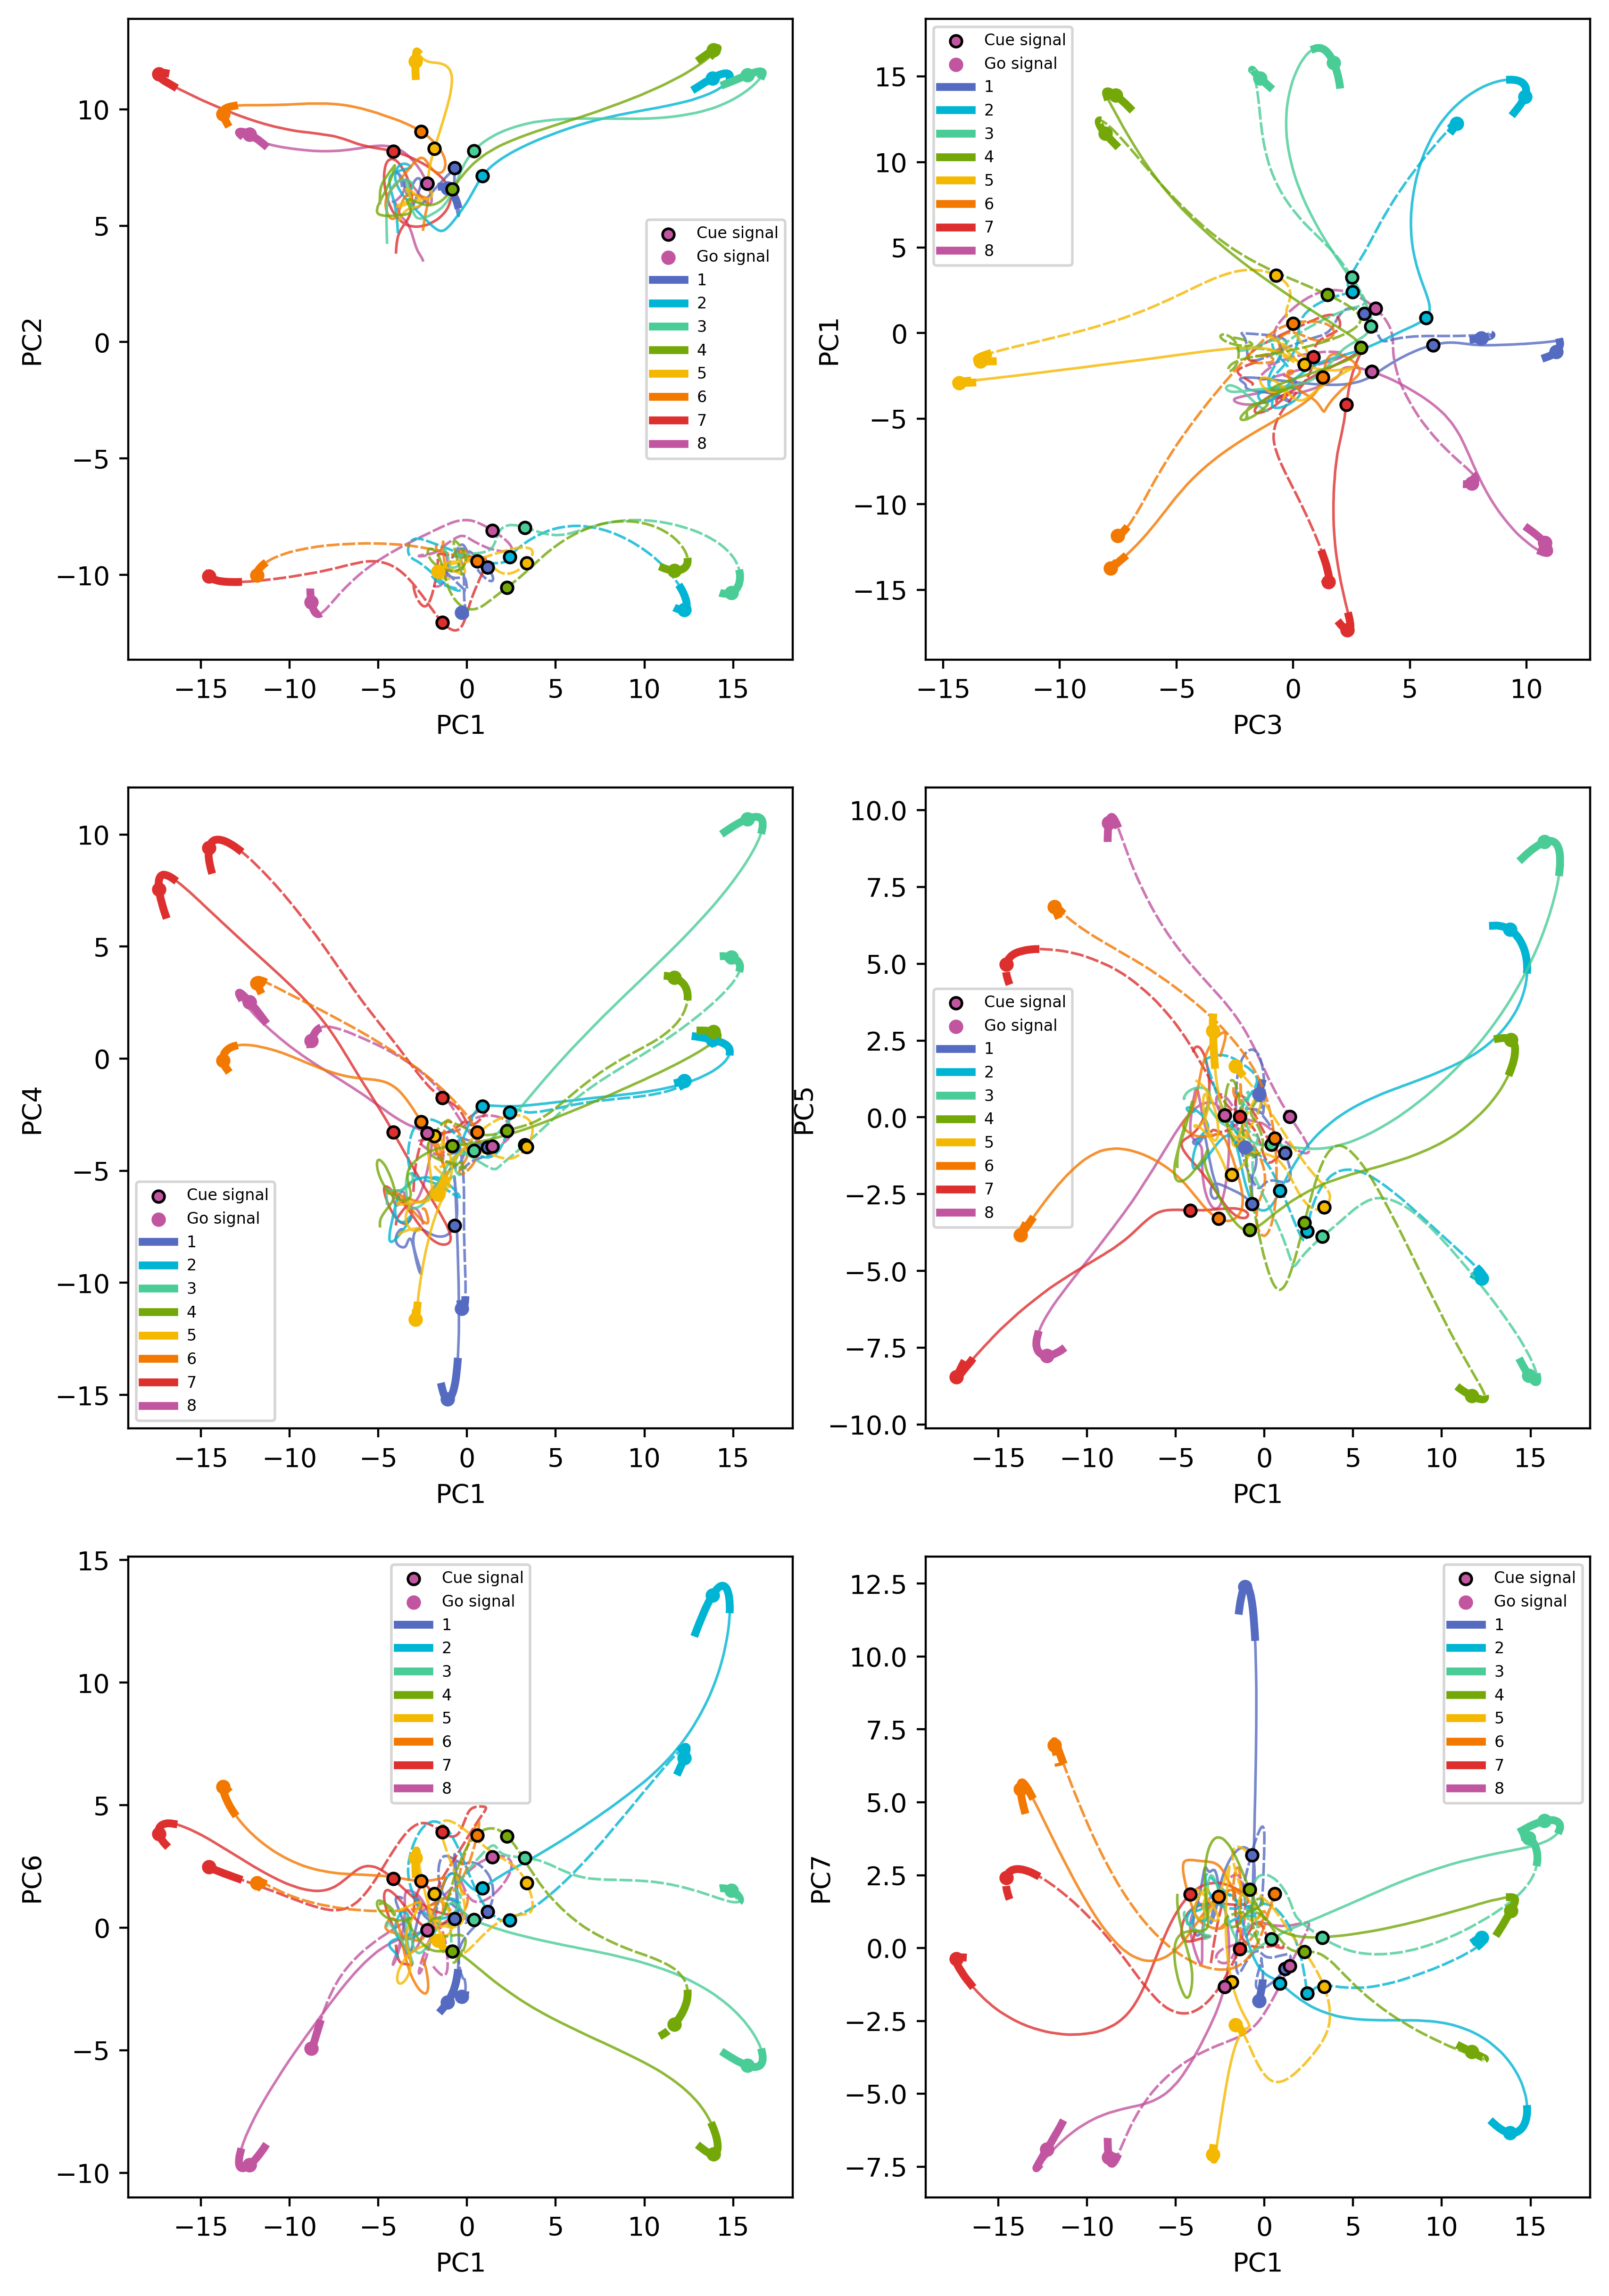

In [71]:
fig, ax = plt.subplots(3, 2, figsize = (10,15), dpi = 400)
colors = np.array([(85, 107, 194), (0, 182, 212), (74, 205, 152),(115, 169, 8), (245, 185, 0), (244, 120, 0), (223, 47, 47), (194, 85, 161)])/256 # ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']   
zordr = np.array([1,3,5,7,6,4,2,0])+100





for row in range(3):
    for col in range(2):
        PC_ref = 0
        i = 7
        PCnumber = col+row*2+1
        
        if PCnumber == 2:
            PCnumber ,PC_ref = PC_ref, PCnumber
            ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k', label = 'Cue signal')
            ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200, label = 'Go signal')

            for i in range(8):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i], zorder = zordr[i])
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i], label=i+1 , zorder = zordr[i])
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200)


            for i in range(8,16):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i%8], zorder = zordr[i%8], linestyle = (0, (5, 1)))
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i%8] , zorder = zordr[i%8], linestyle = (0, (5, 1)))
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i%8], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i%8],marker = 'o', s = 20 , zorder=200)

            ax[row,col].set_xlabel('PC%d'%(PC_ref+1))
            ax[row,col].set_ylabel('PC%d'%(PCnumber+1))
                
        else:
            ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k', label = 'Cue signal')
            ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200, label = 'Go signal')

            for i in range(8):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i], zorder = zordr[i])
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i], label=i+1 , zorder = zordr[i])
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i],marker = 'o', s = 20 , zorder=200)


            for i in range(8,16):

                ax[row,col].plot((neur_states[i,window_size:2000,PC_ref]), (neur_states[i,window_size:2000,PCnumber]) ,alpha = 0.8, linewidth = 1, color = colors[i%8], zorder = zordr[i%8], linestyle = (0, (5, 1)))
                ax[row,col].plot((neur_states[i,t:t+window_size,PC_ref]), (neur_states[i,t:t+window_size,PCnumber]) ,alpha = 1, linewidth = 3, color = colors[i%8] , zorder = zordr[i%8], linestyle = (0, (5, 1)))
                ax[row,col].scatter((neur_states[i,1400,PC_ref]), (neur_states[i,1400,PCnumber]) ,color = colors[i%8], marker = 'o', s = 20 , zorder=200, edgecolors = 'k')
                ax[row,col].scatter((neur_states[i,2000,PC_ref]), (neur_states[i,2000,PCnumber]) ,color = colors[i%8],marker = 'o', s = 20 , zorder=200)

            ax[row,col].set_xlabel('PC%d'%(PC_ref+1))
            ax[row,col].set_ylabel('PC%d'%(PCnumber+1))


        #origin = np.array([-11, -5])
        #xhat = np.array([3, 0])
        #yhat = np.array([0, 3])

        # Plotting 2 unit vectors
        #ax[row,col].arrow(*origin, *xhat, head_width=0.2, color='k')
        #ax[row,col].arrow(*origin, *yhat, head_width=0.2, color='k')
        #ax[row,col].text(-10.5, -6, r'PC1', size = 10)
        #ax[row,col].text(-13.5, -4, r'PC%d'%(PCnumber+1), size = 10)
        ax[row,col].legend(fontsize=6)



#plt.savefig('PCA_cont8_hfs8_6PCs_prep_phase_reordered.pdf', transparent=True, bbox_inches="tight")

In [67]:
i

15

# Making a CCGP analysis for the 2,4,6,8 targets

In [54]:
# Load the data from the .npy files

centering = 'GO'

dic_cont8 = get_data('dic_cont8_'+centering+'.npy')
dic_hfs = get_data('dic_hfs_'+centering+'.npy')
dic_tot = get_data('dic_tot_'+centering+'.npy')

dic_cont8['target'] = np.array(dic_cont8['target'], dtype = 'object')
dic_hfs['target'] = np.array(dic_hfs['target'], dtype = 'object')

# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)
dic_hfs = smoothen_data(dic_hfs, sigma=100)

nb_neurons = len(dic_cont8['target'])

In [55]:
trials_thresh = 0
targets_to_classify = [1,3,5,7]

nb_trials_per_target_control = np.zeros((nb_neurons,8))
nb_trials_per_target_hfs = np.zeros((nb_neurons,8))

for neuron in range(nb_neurons):
    for target in range(8):
        
        nb_trials_per_target_control[neuron, target] = (dic_cont8['target'][neuron] == target+1).sum()
        nb_trials_per_target_hfs[neuron, target] = (dic_hfs['target'][neuron] == target+1).sum()

In [56]:
#neuron filter showing the neurons for which we have at least trials_thresh trials for each of the targets_to_classify
#filter_cont = np.all((nb_trials_per_target_control[:,targets_to_classify] > trials_thresh), axis = 1)
#filter_hfs = np.all((nb_trials_per_target_hfs[:,targets_to_classify] > trials_thresh), axis = 1)

#neuron_filter = (filter_cont*filter_hfs)

In [57]:
t= 1900
window_size = 150


# radomly select trial indices
(trial_indices_to_consider_cont8, trial_indices_to_consider_hfs) = get_rand_tr_indices_same_nbt_per_target(dic_cont8, dic_hfs)

# Add trial-averaged data to the dictionaries and return the neuron filter that has entry 1 if there is at least one recording per target
# for this neuron
(dic_cont8, neuron_filter_cont8) = add_condition_average_to_dic_with_defined_trials(dic_cont8, trial_indices_to_consider_cont8)
(dic_hfs, neuron_filter_hfs) = add_condition_average_to_dic_with_defined_trials(dic_hfs, trial_indices_to_consider_hfs)

# Compute the final neuron filter as the element-wise product of the neuron filters obtained from the two datasets
neuron_filter = neuron_filter_cont8 * neuron_filter_hfs 


## ADD THE ZSCORED MATRICES BASED ON THIS NEURON FILTER AND SELECTED TRIALS
# Get the number of neurons from a previously defined filter
nb_neur = neuron_filter.shape[0]

dic_cont8 = add_zscored_to_dic(dic_cont8, t, window_size, test_set = False)
dic_hfs = add_zscored_to_dic(dic_hfs, t, window_size, test_set = False)
dic_cont8 = add_zscored_trials_to_dic(dic_cont8, t, window_size)
dic_hfs = add_zscored_trials_to_dic(dic_hfs, t, window_size)

### We now have the neurons for which we can train and test a classifier on. Let's build a classifier for certain target discrimination (2vs8 for ex) and test it on others (4vs6) which both are top/bottom discrimination 

In [89]:
dic_cont8['target'][neuron][trial_indices_to_consider_cont8[neuron]]

array([1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 8], dtype=uint8)

In [92]:
ns = np.zeros((nb_neur, window_size))

ttarget = 1

for neuron in range(nb_neur):
    # list of the targets for the corresponding considered trial indices
    target_list = dic_cont8['target'][neuron][trial_indices_to_consider_cont8[neuron]]
    trial_ind = np.random.choice(np.where(target_list == ttarget)[0], size = 1)
    ns[neuron] = dic_cont8['mat_zscored_trials'][neuron][trial_ind,t:t+window_size]
    

In [93]:
ns

array([[ 0.71709149,  0.7418534 ,  0.7666823 , ...,  2.87160304,
         2.863204  ,  2.85442618],
       [-1.26540057, -1.26540057, -1.26540057, ..., -1.26540057,
        -1.26540057, -1.26540057],
       [ 0.97157058,  0.96769128,  0.96371814, ...,  0.33564151,
         0.33545133,  0.3353347 ],
       ...,
       [-2.15867833, -2.16742375, -2.17605895, ..., -1.87851201,
        -1.86501672, -1.85136576],
       [-0.6323726 , -0.65074497, -0.66895341, ..., -1.53910675,
        -1.53701084, -1.53491011],
       [-1.00300604, -1.00300604, -1.00300604, ..., -1.00300604,
        -1.00300604, -1.00300604]])